In [1]:
# default_exp moe

# Price Merit Order Effect Analysis

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fdev-05-price-moe.ipynb)

This notebook outlines the analysis required to determine the price merit-order-effect of variable renewable generation in the GB and DE power markets.

<br>

### Imports

In [2]:
#exports
import json
import pandas as pd
import numpy as np

import pickle
import scipy
from sklearn import linear_model
from sklearn.metrics import r2_score
from collections.abc import Iterable

from tqdm import tqdm

from moepy import lowess, eda
from moepy.surface import PicklableFunction

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import JSON

<br>

### User Inputs

In [10]:
GB_model_fp = '../data/models/DAM_price_GB_p50.pkl'
DE_model_fp = '../data/models/DAM_price_DE_p50.pkl'
load_existing_GB_model = True
load_existing_DE_model = True

<br>

### Estimating the Price Surface

We'll start by loading in the data

In [4]:
%%time

df_EI = eda.load_EI_df('../data/raw/electric_insights.csv')

df_EI.head()

Wall time: 1.76 s


day_ahead_price  SP  imbalance_price  valueSum  \
local_datetime                                                              
2009-01-01 00:00:00+00:00            58.05   1            74.74     74.74   
2009-01-01 00:30:00+00:00            56.33   2            74.89     74.89   
2009-01-01 01:00:00+00:00            52.98   3            76.41     76.41   
2009-01-01 01:30:00+00:00            50.39   4            37.73     37.73   
2009-01-01 02:00:00+00:00            48.70   5            59.00     59.00   

                           temperature  TCO2_per_h  gCO2_per_kWh  nuclear  \
local_datetime                                                              
2009-01-01 00:00:00+00:00         -0.6     21278.0         555.0    6.973   
2009-01-01 00:30:00+00:00         -0.6     21442.0         558.0    6.968   
2009-01-01 01:00:00+00:00         -0.6     21614.0         569.0    6.970   
2009-01-01 01:30:00+00:00         -0.6     21320.0         578.0    6.969   
2009-01-01 02:00:00+00:00         -0.6     21160.0         585.0    6.960   

                           biomass    coal  ...  demand  pumped_storage  \
local_datetime                              ...                           
2009-01-01 00:00:00+00:00      0.0  17.650  ...  38.329          -0.404   
2009-01-01 00:30:00+00:00      0.0  17.770  ...  38.461          -0.527   
2009-01-01 01:00:00+00:00      0.0  18.070  ...  37.986          -1.018   
2009-01-01 01:30:00+00:00      0.0  18.022  ...  36.864          -1.269   
2009-01-01 02:00:00+00:00      0.0  17.998  ...  36.180          -1.566   

                           wind_onshore  wind_offshore  belgian  dutch  \
local_datetime                                                           
2009-01-01 00:00:00+00:00           NaN            NaN      0.0    0.0   
2009-01-01 00:30:00+00:00           NaN            NaN      0.0    0.0   
2009-01-01 01:00:00+00:00           NaN            NaN      0.0    0.0   
2009-01-01 01:30:00+00:00           NaN            NaN      0.0    0.0   
2009-01-01 02:00:00+00:00           NaN            NaN      0.0    0.0   

                           french  ireland  northern_ireland  irish  
local_datetime                                                       
2009-01-01 00:00:00+00:00   1.977      0.0               0.0 -0.161  
2009-01-01 00:30:00+00:00   1.977      0.0               0.0 -0.160  
2009-01-01 01:00:00+00:00   1.977      0.0               0.0 -0.160  
2009-01-01 01:30:00+00:00   1.746      0.0               0.0 -0.160  
2009-01-01 02:00:00+00:00   1.730      0.0               0.0 -0.160  

[5 rows x 24 columns]

<br>

We'll do a quick plot of the average price

Text(0, 0.5, 'Day-Ahead Price\nMonthly Average (£/MWh)')

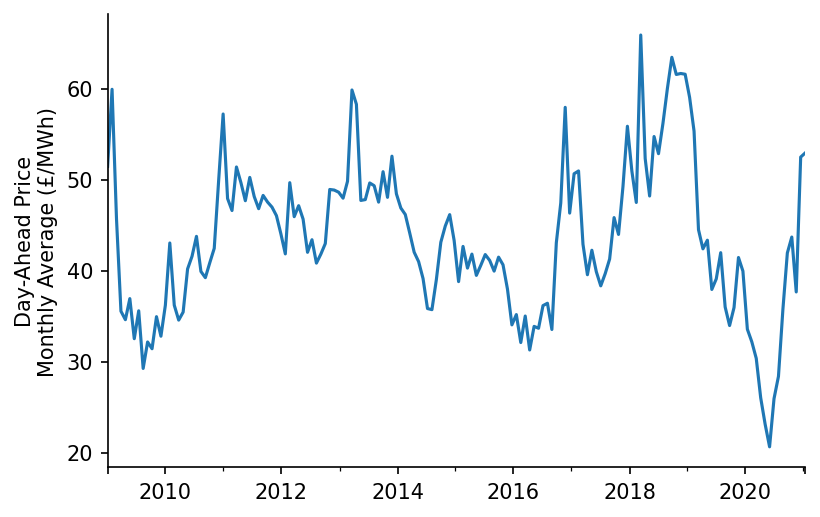

In [5]:
fig, ax = plt.subplots(dpi=150)

df_EI['day_ahead_price'].resample('4W').mean().plot(ax=ax)

eda.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Day-Ahead Price\nMonthly Average (£/MWh)')

<br>

We'll also visualise individual half-hour periods for two different date ranges in the dataset

Text(0, 0.5, 'Price (£/MWh)')

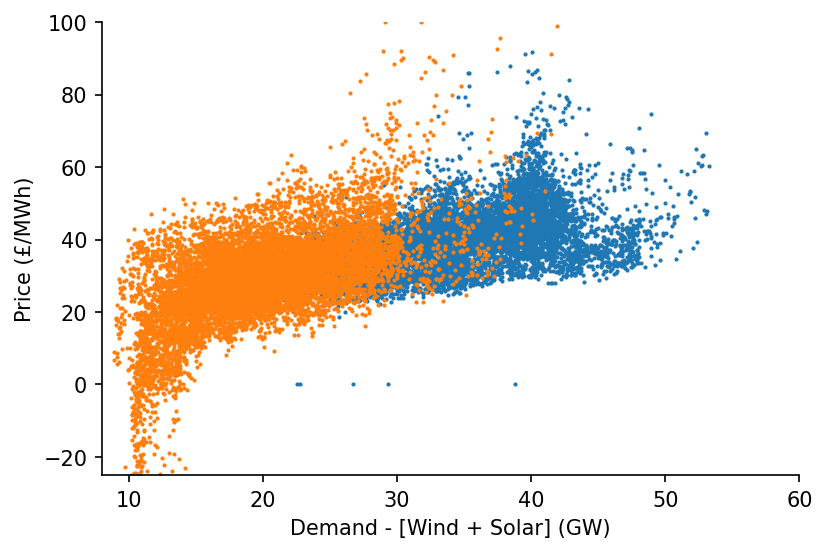

In [6]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-03':'2010-09'], s_price['2010-03':'2010-09'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

eda.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('Price (£/MWh)')

<br>

Next we'll load in (or fit) one of the models trained in the previous notebook

In [11]:
%%time

if load_existing_GB_model == True:
    smooth_dates = pickle.load(open(GB_model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

Wall time: 2.42 s


<br>

We're now ready to make our price curve predictions, we'll make one for each day that the model used in training

In [12]:
%%time

x_pred = np.linspace(3, 61, 581)
dt_pred = pd.date_range('2009-01-01', '2020-12-31', freq='1D')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
df_pred.index = np.round(df_pred.index, 1)

df_pred.head()

Wall time: 469 ms


2009-01-01  2009-01-02  2009-01-03  2009-01-04  2009-01-05  2009-01-06  \
3.0  -17.494810  -17.517832  -17.540635  -17.563220  -17.585587  -17.607740   
3.1  -17.296395  -17.319349  -17.342086  -17.364604  -17.386906  -17.408993   
3.2  -17.098313  -17.121198  -17.143867  -17.166318  -17.188552  -17.210574   
3.3  -16.900560  -16.923375  -16.945975  -16.968357  -16.990523  -17.012478   
3.4  -16.703132  -16.725876  -16.748404  -16.770717  -16.792814  -16.814700   

     2009-01-07  2009-01-08  2009-01-09  2009-01-10  ...  2020-12-22  \
3.0  -17.629683  -17.651422  -17.672962  -17.694305  ...    0.194247   
3.1  -17.430873  -17.452548  -17.474024  -17.495305  ...    0.404498   
3.2  -17.232388  -17.253998  -17.275410  -17.296628  ...    0.614692   
3.3  -17.034225  -17.055769  -17.077116  -17.098268  ...    0.824815   
3.4  -16.836379  -16.857856  -16.879136  -16.900222  ...    1.034856   

     2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  2020-12-28  \
3.0    0.203242    0.212319    0.221479    0.230719    0.240041    0.249444   
3.1    0.413478    0.422540    0.431683    0.440907    0.450212    0.459598   
3.2    0.623656    0.632702    0.641829    0.651037    0.660326    0.669695   
3.3    0.833764    0.842794    0.851906    0.861097    0.870370    0.879722   
3.4    1.043790    1.052805    1.061900    1.071076    1.080332    1.089667   

     2020-12-29  2020-12-30  2020-12-31  
3.0    0.258926    0.268489    0.278132  
3.1    0.469064    0.478609    0.488234  
3.2    0.679143    0.688671    0.698278  
3.3    0.889153    0.898664    0.908253  
3.4    1.099082    1.108575    1.118147  

[5 rows x 4383 columns]

<br>

### Visualising the Price Surface

We now want to actually visualise the results of our model, in particular the price surface it's fitted. We'll start by plotting all of the price curves overlapping each other.

Text(0.5, 1.0, 'Day-Ahead Market Average Price Curve')

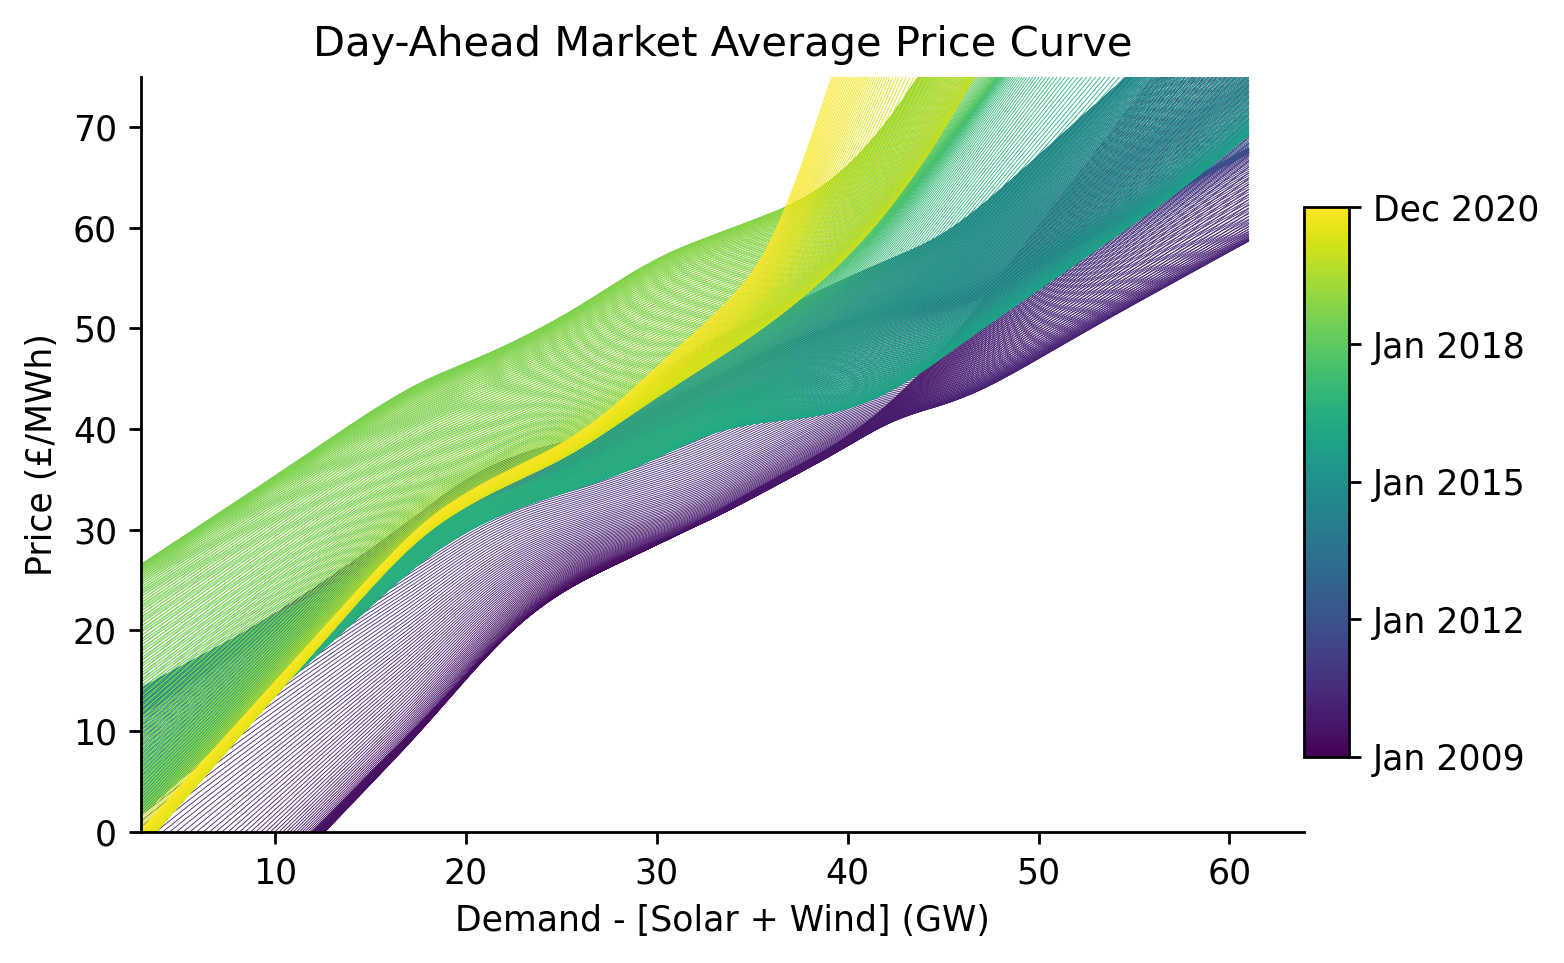

In [13]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.loc[:, ::7].plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

eda.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 75)
ax.set_title('Day-Ahead Market Average Price Curve')

<br>

Whilst the previous plot might look quite nice it's rather difficult to interpret, an alternative way to visualise how the price curve evolves over time is using a heatmap

In [14]:
#exports
def construct_dispatchable_lims_df(s_dispatchable, rolling_w=3, daily_quantiles=[0.001, 0.999]):
    """Identifies the rolling limits to be used in masking"""
    df_dispatchable_lims = (s_dispatchable
                            .resample('1d')
                            .quantile(daily_quantiles)
                            .unstack()
                            .rolling(rolling_w*7)
                            .mean()
                            .bfill()
                            .ffill()
                            .iloc[:-1, :]
                           )
    
    df_dispatchable_lims.index = pd.to_datetime(df_dispatchable_lims.index.strftime('%Y-%m-%d'))
    
    return df_dispatchable_lims

def construct_pred_mask_df(df_pred, df_dispatchable_lims):
    """Constructs a DataFrame mask for the prediction"""
    df_pred = df_pred[df_dispatchable_lims.index]
    df_pred_mask = pd.DataFrame(dict(zip(df_pred.columns, [df_pred.index]*df_pred.shape[1])), index=df_pred.index)
    df_pred_mask = (df_pred_mask > df_dispatchable_lims.iloc[:, 0].values) & (df_pred_mask < df_dispatchable_lims.iloc[:, 1].values)

    df_pred.columns = pd.to_datetime(df_pred.columns)
    df_pred_mask.columns = pd.to_datetime(df_pred_mask.columns)
    
    return df_pred_mask

<AxesSubplot:>

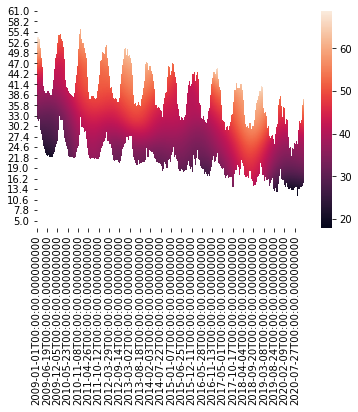

In [15]:
df_dispatchable_lims = construct_dispatchable_lims_df(s_dispatchable)
df_pred_mask = construct_pred_mask_df(df_pred, df_dispatchable_lims)

sns.heatmap(df_pred.where(df_pred_mask, np.nan).iloc[::-1])

<br>

The default output for `seaborn` heatmaps never looks great when one of the axis is a datetime, we'll write a custom class and wrapper to handle this

In [16]:
#exports
class AxTransformer:
    """Helper class for cleaning axis tick locations and labels"""
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs

def set_ticks(ax, tick_locs, tick_labels=None, axis='y'):
    """Sets ticks at standard numerical locations"""
    if tick_labels is None:
        tick_labels = tick_locs
    ax_transformer = AxTransformer()
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(tick_locs))
    getattr(ax, f'set_{axis}ticklabels')(tick_labels)
    
    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    """Sets ticks at datetime locations"""
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))
    
    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

Wall time: 1.79 s


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Text(144.58333333333331, 0.5, 'Demand - [Solar + Wind] (GW)')

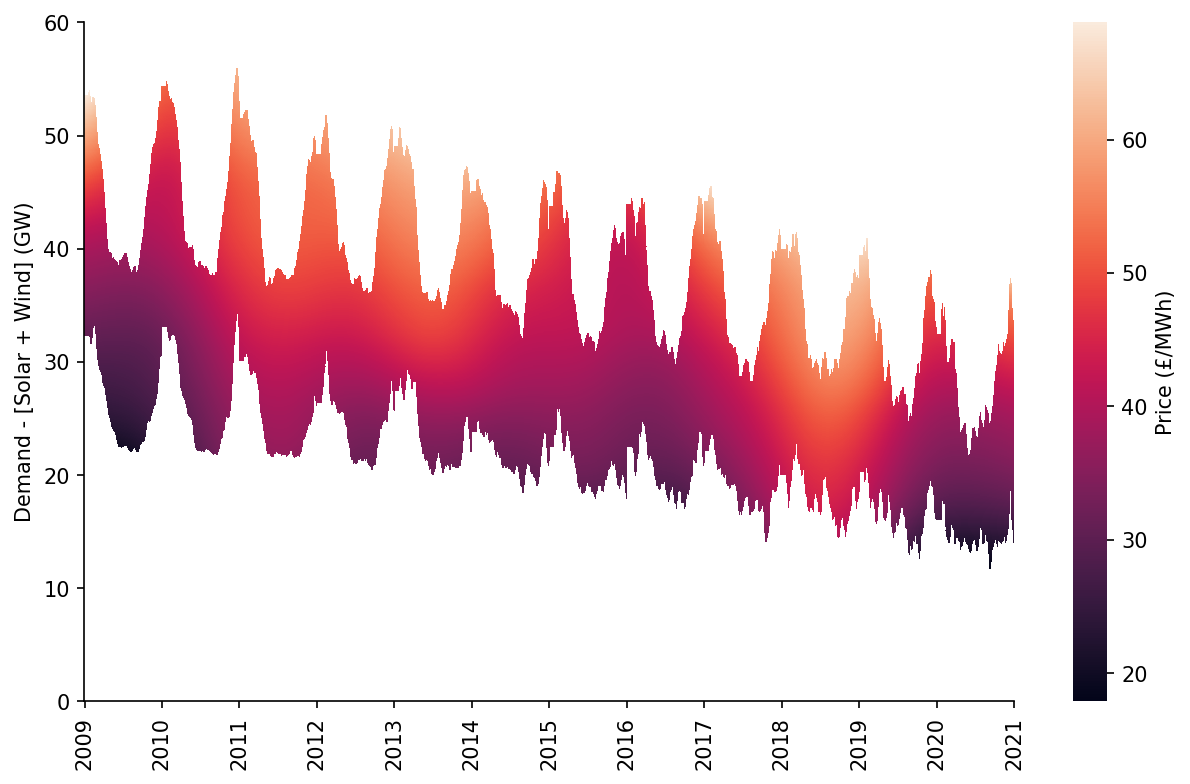

In [17]:
%%time

fig, ax = plt.subplots(dpi=150, figsize=(10, 6))

htmp = sns.heatmap(df_pred[10:60].where(df_pred_mask[10:60], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (£/MWh)'})

set_ticks(ax, np.arange(0, 70, 10), axis='y')
set_date_ticks(ax, '2009-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
eda.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

<br>

We also want to visualise specific date ranges, here we'll look towards the end of 2020

Wall time: 58.1 ms


C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

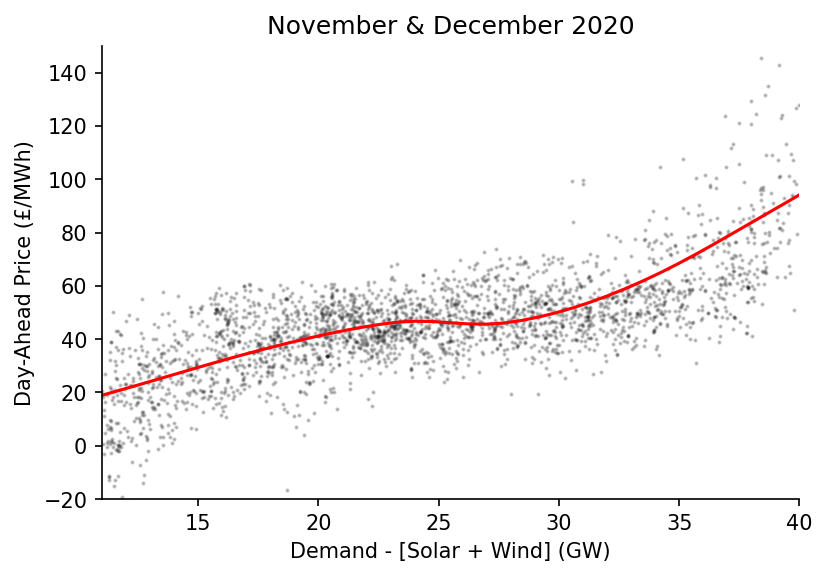

In [18]:
%%time

center_date = '2020-12-01'

dt_min = pd.to_datetime(center_date) - pd.Timedelta(weeks=4)
dt_max = pd.to_datetime(center_date) + pd.Timedelta(weeks=4)

x = s_dispatchable[dt_min:dt_max].values
y = s_price.loc[s_dispatchable.index][dt_min:dt_max].values

x_pred = np.linspace(11, 40, 41)
y_pred = lowess.lowess_fit_and_predict(x, y, frac=0.6, num_fits=25, x_pred=x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, linewidth=1.5, color='r')
ax.scatter(x, y, color='k', s=1, alpha=0.2)

ax.set_title(f'November & December 2020') # remove in the LaTeX plot and just state in the caption
ax.set_xlim(11, 40)
ax.set_ylim(-20, 150)
eda.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

<br>

### Evaluating the Price Curve Predictions

In [15]:
#exports
def construct_df_pred(model_fp, x_pred=np.linspace(-2, 61, 631), dt_pred=pd.date_range('2009-01-01', '2020-12-31', freq='1D')):
    """Constructs the prediction surface for the specified pre-fitted model"""
    smooth_dates = pickle.load(open(model_fp, 'rb'))
    df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
    df_pred.index = np.round(df_pred.index, 1)
    
    return df_pred

In [16]:
model_fp = '../data/models/DAM_price_average.pkl'

df_pred = construct_df_pred(model_fp)

df_pred.head()

2009-01-01  2009-01-02  2009-01-03  2009-01-04  2009-01-05  2009-01-06  \
-2.0  -28.412220  -28.430584  -28.448767  -28.466768  -28.484586  -28.502217   
-1.9  -28.217121  -28.235428  -28.253553  -28.271497  -28.289259  -28.306836   
-1.8  -28.022024  -28.040273  -28.058341  -28.076228  -28.093934  -28.111455   
-1.7  -27.826927  -27.845118  -27.863129  -27.880959  -27.898609  -27.916074   
-1.6  -27.631830  -27.649963  -27.667916  -27.685690  -27.703284  -27.720693   

      2009-01-07  2009-01-08  2009-01-09  2009-01-10  ...  2020-12-22  \
-2.0  -28.519660  -28.536910  -28.553964  -28.570820  ...  -17.546472   
-1.9  -28.324223  -28.341419  -28.358419  -28.375222  ...  -17.297928   
-1.8  -28.128787  -28.145928  -28.162875  -28.179624  ...  -17.049353   
-1.7  -27.933352  -27.950439  -27.967332  -27.984028  ...  -16.800758   
-1.6  -27.737916  -27.754949  -27.771788  -27.788431  ...  -16.552156   

      2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  2020-12-28  \
-2.0  -17.539855  -17.533145  -17.526343  -17.519449  -17.512463  -17.505383   
-1.9  -17.291305  -17.284592  -17.277786  -17.270888  -17.263898  -17.256815   
-1.8  -17.042726  -17.036007  -17.029198  -17.022296  -17.015302  -17.008216   
-1.7  -16.794127  -16.787404  -16.780590  -16.773684  -16.766687  -16.759597   
-1.6  -16.545520  -16.538792  -16.531974  -16.525065  -16.518063  -16.510970   

      2020-12-29  2020-12-30  2020-12-31  
-2.0  -17.498210  -17.490944  -17.483584  
-1.9  -17.249639  -17.242370  -17.235007  
-1.8  -17.001037  -16.993765  -16.986400  
-1.7  -16.752415  -16.745141  -16.737773  
-1.6  -16.503785  -16.496508  -16.489138  

[5 rows x 4383 columns]

<br>

Now we've created our prediction dataframe we can calculate a time-series for our price prediction

N.b. to speed things up every 100th half-hour has been sampled rather than using the full dataset

In [17]:
#exports
def construct_pred_ts(s, df_pred):
    """Uses the time-adaptive LOWESS surface to generate time-series prediction"""
    s_pred_ts = pd.Series(index=s.index, dtype='float64')

    for dt_idx, val in tqdm(s.iteritems(), total=s.size):
        s_pred_ts.loc[dt_idx] = df_pred.loc[round(val, 1), dt_idx.strftime('%Y-%m-%d')]
        
    return s_pred_ts

In [18]:
s_dispatchable = (df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)).dropna().loc[:df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]

s_pred_ts = construct_pred_ts(s_dispatchable.iloc[::100].iloc[:-1], df_pred)

s_pred_ts.head()

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 2095/2095 [00:02<00:00, 0.00s/it]

local_datetime
2009-01-01 00:00:00+00:00    39.026220
2009-01-03 02:00:00+00:00    34.314689
2009-01-05 04:00:00+00:00    32.502689
2009-01-07 06:00:00+00:00    42.705269
2009-01-09 08:00:00+00:00    64.025113
dtype: float64

<br>

We'll quickly inspect the error distribution

6.8625170828105615


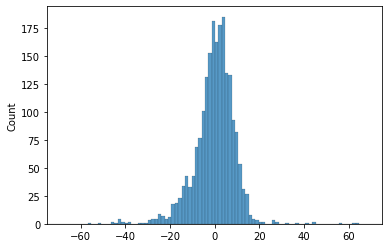

In [19]:
s_price = df_EI['day_ahead_price']

s_err = s_pred_ts - s_price.loc[s_pred_ts.index]
print(s_err.abs().mean())

sns.histplot(s_err)
_ = plt.xlim(-75, 75)

<br>

We'll quickly calculate the r2 score for this model, for context the UK day-ahead price multiple linear regression model from the Staffell/Green group achieved an adjusted r2 of <b>0.451</b>

In [20]:
r2_score(s_price.loc[s_pred_ts.index], s_pred_ts)

0.46527623686663677

<br>

Now we'll calculate some error metrics, including the option to remove extreme error outliers

In [21]:
#exports
def calc_error_metrics(s_err, max_err_quantile=1):
    """Calculates several error metrics using the passed error series"""
    if s_err.isnull().sum() > 0:
        s_err = s_err.dropna()
        
    max_err_cutoff = s_err.abs().quantile(max_err_quantile)
    s_err = s_err[s_err.abs()<=max_err_cutoff]
    
    metrics = {
        'median_abs_err': s_err.abs().median(),
        'mean_abs_err': s_err.abs().mean(),
        'root_mean_square_error': np.sqrt((s_err**2).mean())
    }
    
    return metrics

In [22]:
metrics = calc_error_metrics(s_err)

metrics

{'median_abs_err': 4.843738852384298,
 'mean_abs_err': 6.8625170828105615,
 'root_mean_square_error': 12.301327313943641}

<br>

We'll now create a wrapper for the last few steps and repeat the analysis for four variants of the model

In [23]:
#exports
def get_model_pred_ts(s, model_fp, s_demand=None, x_pred=np.linspace(-2, 61, 631), dt_pred=pd.date_range('2009-01-01', '2020-12-31', freq='1D')):
    """Constructs the time-series prediction for the specified pre-fitted model"""
    df_pred = construct_df_pred(model_fp, x_pred=x_pred, dt_pred=dt_pred)
    s_cleaned = s.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
    s_pred_ts = construct_pred_ts(s_cleaned, df_pred)
    
    if s_demand is None:
        return s_pred_ts
    else:
        s_cleaned = s_demand.dropna().loc[df_pred.columns.min():df_pred.columns.max()+pd.Timedelta(hours=23, minutes=30)]
        s_pred_ts_demand = construct_pred_ts(s_cleaned, df_pred)
        return s_pred_ts, s_pred_ts_demand

In [24]:
s_demand = df_EI['demand']
s_price = df_EI['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

model_runs = {
    'demand_p50': {
        'model_fp': '../data/models/DAM_price_demand_p50.pkl',
        's': s_demand
    },
    'demand_avg': {
        'model_fp': '../data/models/DAM_price_demand_average.pkl',
        's': s_demand
    },
    'dispatch_p50': {
        'model_fp': '../data/models/DAM_price_p50.pkl',
        's': s_dispatchable
    },
    'dispatch_avg': {
        'model_fp': '../data/models/DAM_price_average.pkl',
        's': s_dispatchable
    },
}

model_outputs = dict()

for model_name, model_kwargs in tqdm(model_runs.items()):
    s_pred_ts = get_model_pred_ts(**model_kwargs)
    s_err = s_pred_ts - s_price.loc[s_pred_ts.index]
    metrics = calc_error_metrics(s_err)
    
    model_outputs[model_name] = {
        's_pred_ts': s_pred_ts,
        's_err': s_err,
        'metrics': metrics
    }

 [████████████████████████████████████████████████████████████] 4/4 [11:27<02:57, 171.67s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209736/209736 [02:23<00:00, 0.00s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209736/209736 [02:26<00:00, 0.00s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209533/209533 [03:30<00:00, 0.00s/it]

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


 [████████████████████████████████████████████████████████████] 209533/209533 [02:53<00:00, 0.00s/it]

<br>

Overall, the dispatch model fitted to the median price appears to be the most accurate

In [25]:
df_metrics = pd.DataFrame({
    name: outputs['metrics'] 
    for name, outputs 
    in model_outputs.items()
})

df_metrics

demand_p50  demand_avg  dispatch_p50  dispatch_avg
median_abs_err            4.705342    5.049710      4.473115      4.777677
mean_abs_err              6.974887    7.090144      6.556877      6.651800
root_mean_square_error   12.632306   12.409950     12.053854     11.807459

<br>

We'll quantify the difference against the standard LOWESS approach

In [26]:
old_err = df_metrics.loc['mean_abs_err', 'dispatch_avg']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_p50']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the p50 model rather than the average model')

1.43% mean absolute error reduction using the p50 model rather than the average model


<br>

And also look at the improvement in accuracy when regressing against dispatchable generation instead of total generation

In [27]:
old_err = df_metrics.loc['mean_abs_err', 'demand_avg']
new_err = df_metrics.loc['mean_abs_err', 'dispatch_avg']

print(f'{-100*(new_err - old_err)/old_err:.2f}% mean absolute error reduction using the dispatchable demand model rather than just demand')

6.18% mean absolute error reduction using the dispatchable demand model rather than just demand


<br>

### Quantifying & Visualising the Merit Order Effect

To begin we'll load up our dispatchable supply model and make an inference for each half-hour in the dataset, based on the results in the previous section we'll use the p50 model.

In [79]:
%%time

s_GB_demand = df_EI_model['demand']
s_GB_price = df_EI_model['day_ahead_price']
s_GB_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

s_GB_pred_ts_dispatch, s_GB_pred_ts_demand = get_model_pred_ts(s_GB_dispatchable, GB_model_fp, s_demand=s_GB_demand)

s_dispatch_GB_err = s_GB_pred_ts_dispatch - s_GB_price.loc[s_GB_pred_ts_dispatch.index]
GB_dispatch_metrics = calc_error_metrics(s_dispatch_GB_err)

s_demand_GB_err = s_GB_pred_ts_demand - s_GB_price.loc[s_GB_pred_ts_demand.index]
GB_demand_metrics = calc_error_metrics(s_demand_GB_err)

s_GB_pred_ts_dispatch

Wall time: 92.1 ms


local_datetime
2009-01-01 00:00:00+00:00    37.203441
2009-01-01 00:30:00+00:00    37.313379
2009-01-01 01:00:00+00:00    36.768513
2009-01-01 01:30:00+00:00    35.595162
2009-01-01 02:00:00+00:00    34.849422
                               ...    
2020-12-30 21:30:00+00:00    48.066638
2020-12-30 22:00:00+00:00    45.268069
2020-12-30 22:30:00+00:00    42.647597
2020-12-30 23:00:00+00:00    39.520118
2020-12-30 23:30:00+00:00    37.948852
Length: 209533, dtype: float64

<br>

The difference between the price forecast when using the dispatchable generation and total generation is due to the merit order effect

<AxesSubplot:xlabel='local_datetime'>

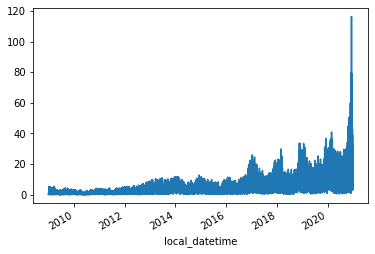

In [29]:
s_GB_MOE = s_GB_pred_ts_demand - s_GB_pred_ts_dispatch
s_GB_MOE = s_GB_MOE.dropna()

s_GB_MOE.plot()

<br>

We'll quickly calculate the averages for 2010 and 2020

In [30]:
s_GB_MOE['2010'].mean(), s_GB_MOE['2020'].mean()

(0.8813580281178922, 13.888630517942211)

<br>

We'll also visualise the predictions for a sample day

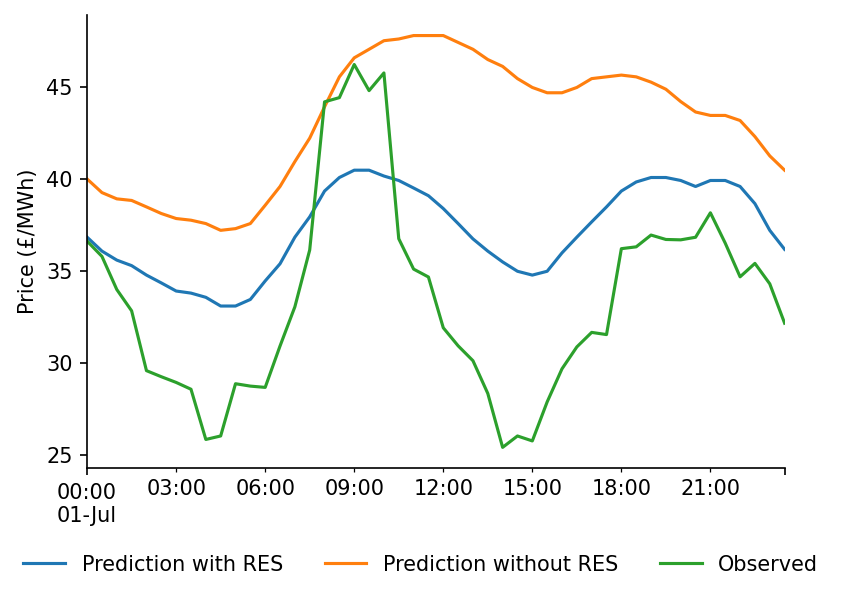

In [32]:
date = '2017-07-01'

# Plotting
fig, ax = plt.subplots(dpi=150)

s_GB_pred_ts_dispatch[date].plot(label='Prediction with RES', ax=ax)
s_GB_pred_ts_demand[date].plot(label='Prediction without RES', ax=ax)
s_GB_price[date].plot(label='Observed', ax=ax)

ax.legend(frameon=False, ncol=3, bbox_to_anchor=(1.075, -0.15))
ax.set_xlabel('')
ax.set_ylabel('Price (£/MWh)')
eda.hide_spines(ax)

<br>

We can see that there is a clear pattern in the bias over the course of the day

<AxesSubplot:xlabel='local_datetime'>

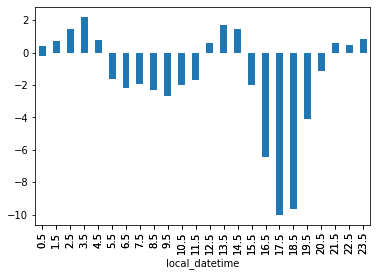

In [34]:
s_GB_err.groupby(s_GB_err.index.hour+s_GB_err.index.minute/60).mean().plot.bar()

<br>

We'll now calculate the half-hourly savings due to the merit order effect. The demand is expressed in terms of GW which we'll convert into MWh to be compatible with the units of the merit order effect.

<AxesSubplot:xlabel='local_datetime'>

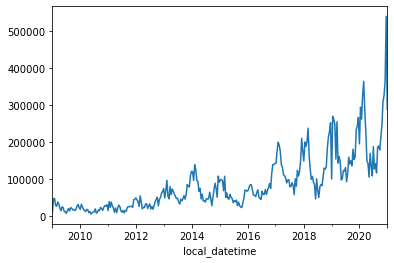

In [35]:
s_GB_saving = s_GB_MOE * s_GB_demand.loc[s_GB_MOE.index]*1000*0.5

s_GB_saving.resample('2W').mean().plot()

<br>

The distribution of the price savings appears to follow a rough Pareto distribution

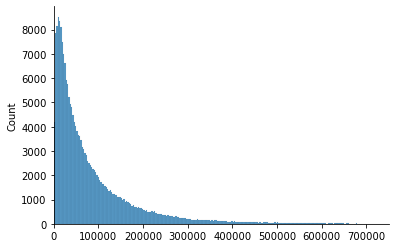

In [36]:
sns.histplot(s_GB_saving)
plt.xlim(0, 750000)
eda.hide_spines(plt.gca())

<br>

We'll calculate the total savings over the dataset period

In [37]:
start_date = '2010'
end_date = '2020'

total_saving = s_GB_saving[start_date:end_date].sum()

print(f"The total saving between {start_date} and {end_date} was £{total_saving:,.0f}")

The total saving between 2010 and 2020 was £17,454,468,143


<br>

To add some context we'll calculate the average half-hourly market volume (note that the DAM volume will be smaller than demand but it acts as a good proxy to cover all markets)

In [38]:
s_mkt_cost = df_EI['day_ahead_price']*df_EI['demand']*1000*0.5
avg_HH_mkt_cost = s_mkt_cost.mean()

avg_HH_mkt_cost

784440.8559554707

<br>

We'll also calculate the long-term price reduction due to the merit order effect

In [92]:
s_GB_MOE[start_date:end_date].mean()/(df_EI['day_ahead_price']+s_GB_MOE)[start_date:end_date].mean()

0.15034496268274428

<br>

This only tells part of the story though, lets look at how this value evolves over time

<AxesSubplot:xlabel='local_datetime'>

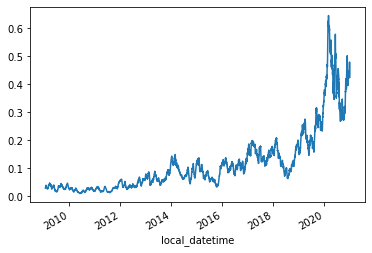

In [40]:
s_GB_DAM = s_GB_price.loc[s_GB_MOE.index]

s_GB_MOE_rolling = s_GB_MOE.rolling(48*28).mean().dropna()
s_GB_DAM_rolling = s_GB_DAM.rolling(48*28).mean().dropna()

s_GB_MOE_pct_reduction = s_GB_MOE_rolling/s_GB_DAM_rolling

s_GB_MOE_pct_reduction.plot()

<br>

We're half-way to creating the metrics required for comparing between markets of different sizes, prices and RES penetration. We'll calculate the renewables penetration percentage and then aggregate it on an annual basis alongside the pct price reduction due to the MOE.

Wall time: 753 ms


Text(0, 0.5, 'Average MOE Price Reduction (%)')

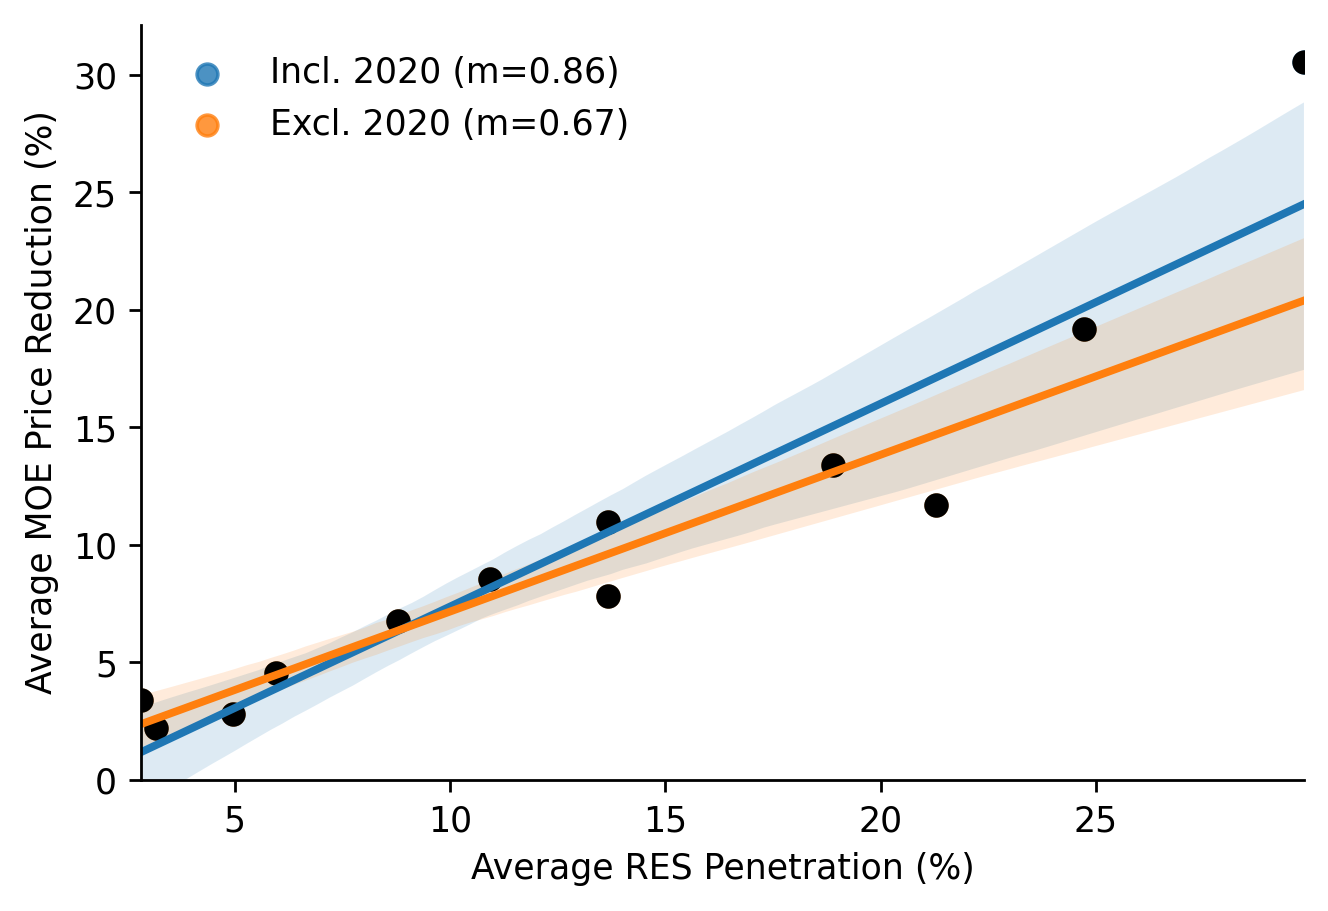

In [125]:
%%time

s_GB_MOE_pct_annual_avg = (s_GB_MOE/(df_EI.loc[s_GB_MOE.index]['day_ahead_price']+s_GB_MOE)).replace(np.inf, np.nan).dropna().pipe(lambda s: s.groupby(s.index.year).mean())
s_GB_RES_pct_annual_avg = (df_EI[['wind', 'solar']].sum(axis=1)/df_EI['demand']).pipe(lambda s: s.groupby(s.index.year).mean())

# Plotting
fig, ax = plt.subplots(dpi=250)

sns.regplot(x=100*s_GB_RES_pct_annual_avg, y=100*s_GB_MOE_pct_annual_avg, ax=ax, label='Incl. 2020 (m=0.86)')
sns.regplot(x=100*s_GB_RES_pct_annual_avg.loc[:2019], y=100*s_GB_MOE_pct_annual_avg.loc[:2019], truncate=False, ax=ax, label='Excl. 2020 (m=0.67)')
ax.scatter(x=100*s_GB_RES_pct_annual_avg, y=100*s_GB_MOE_pct_annual_avg, color='k')

eda.hide_spines(ax)
ax.legend(frameon=False, loc='upper left')
ax.set_ylim(0)
ax.set_xlabel('Average RES Penetration (%)')
ax.set_ylabel('Average MOE Price Reduction (%)')

<br>

We'll fit a linear regression that includes 2020

In [121]:
linreg_results = scipy.stats.linregress(x=s_GB_RES_pct_annual_avg, y=s_GB_MOE_pct_annual_avg)

linreg_results

LinregressResult(slope=0.8635390661954275, intercept=-0.01260770809733558, rvalue=0.9407770535093302, pvalue=5.192107447861512e-06, stderr=0.0984074783808127, intercept_stderr=0.01545140550162944)

<br>

And one that excludes 2020

In [122]:
max_year = 2019
linreg_results = scipy.stats.linregress(x=s_GB_RES_pct_annual_avg.loc[:max_year], y=s_GB_MOE_pct_annual_avg.loc[:max_year])

linreg_results

LinregressResult(slope=0.6675133238057994, intercept=0.004850800918389769, rvalue=0.9588281998847612, pvalue=3.215977627236812e-06, stderr=0.06590160431497857, intercept_stderr=0.009037033037260158)

<br>

We'll also visualise the how the MOE time-series and trend

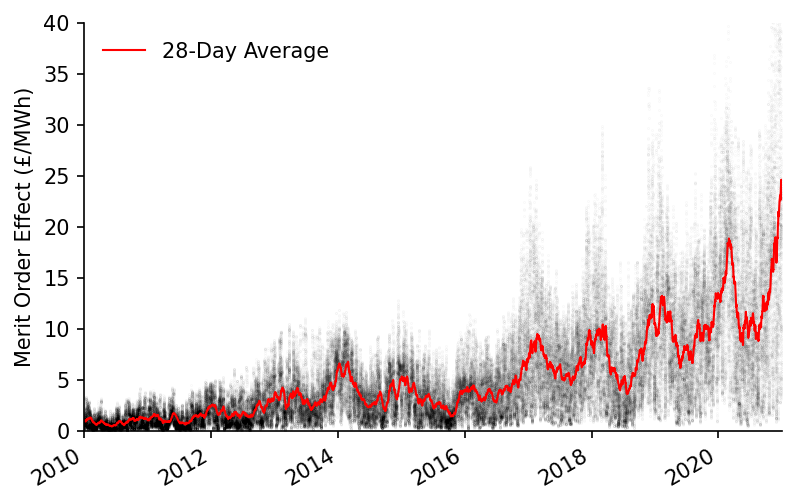

In [42]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_GB_MOE.index, s_GB_MOE, s=0.01, alpha=0.1, color='k', label=None)
s_GB_MOE_rolling.plot(color='r', linewidth=1, ax=ax, label='28-Day Average')

eda.hide_spines(ax)
ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)

<br>

We can also attribute specific savings from the MOE to the different RES technologies

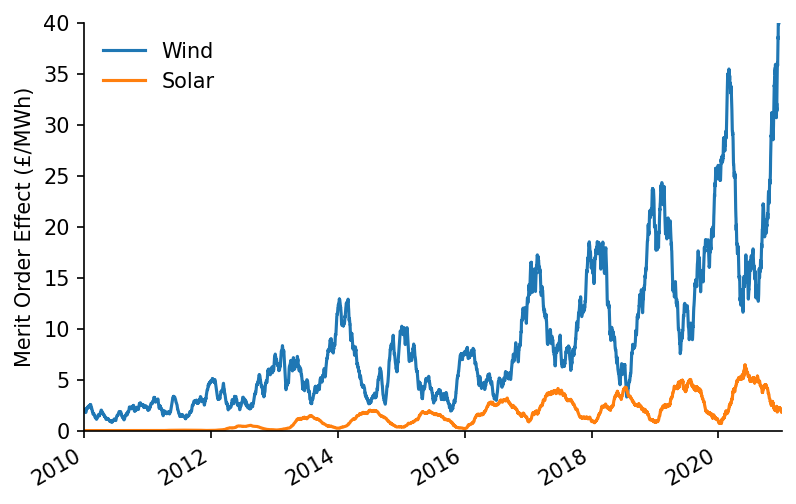

In [43]:
wind_weight = df_EI.loc[s_GB_MOE.index, 'wind']/df_EI.loc[s_GB_MOE.index][['wind', 'solar']].mean(axis=1)
solar_weight = df_EI.loc[s_GB_MOE.index, 'solar']/df_EI.loc[s_GB_MOE.index][['wind', 'solar']].mean(axis=1)

s_wind_MOE = s_GB_MOE*wind_weight
s_solar_MOE = s_GB_MOE*solar_weight

# Plotting
fig, ax = plt.subplots(dpi=150)

s_wind_MOE.rolling(48*28).mean().plot(ax=ax, label='Wind')
s_solar_MOE.rolling(48*28).mean().plot(ax=ax, label='Solar')

ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)
eda.hide_spines(ax)

<br>

To add some context we'll plot the MOE alongside the actual price, we'll also do this for both years at the extremes of the dataset time range

Text(0, 0.5, 'Price (£/MWh)')

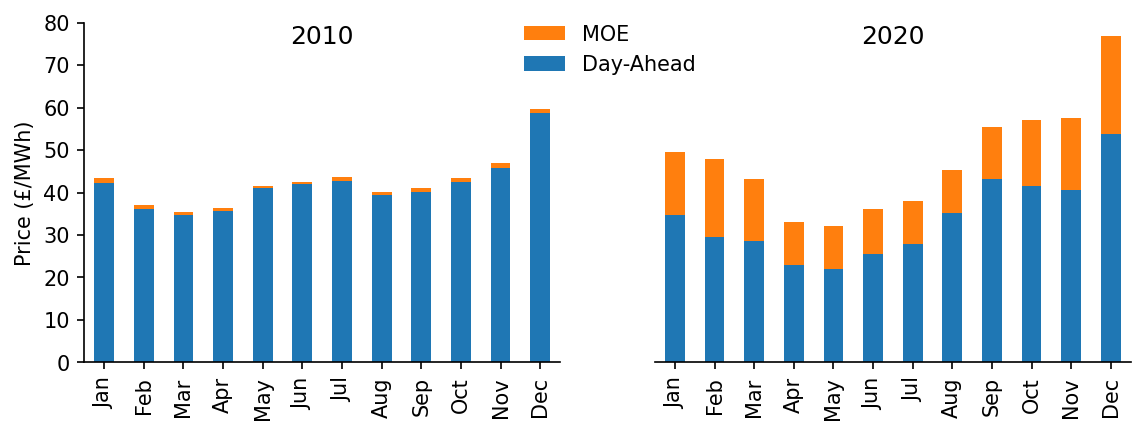

In [44]:
year_1 = '2010'
year_2 = '2020'

month_num_to_name = dict(zip(np.arange(1, 13), pd.date_range('2010-01-01', '2010-12-31', freq='M').strftime('%b')))

s_hourly_dam_10 = s_GB_DAM[year_1].groupby(s_GB_DAM[year_1].index.month).mean()
s_hourly_MOE_10 = s_GB_MOE[year_1].groupby(s_GB_MOE[year_1].index.month).mean()

s_hourly_dam_20 = s_GB_DAM[year_2].groupby(s_GB_DAM[year_2].index.month).mean()
s_hourly_MOE_20 = s_GB_MOE[year_2].groupby(s_GB_MOE[year_2].index.month).mean()

for s in [s_hourly_dam_10, s_hourly_MOE_10, s_hourly_dam_20, s_hourly_MOE_20]:
    s.index = s.index.map(month_num_to_name)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(9, 3))

(s_hourly_dam_10+s_hourly_MOE_10).plot.bar(color='C1', label='MOE', ax=axs[0])
s_hourly_dam_10.plot.bar(label='Price', ax=axs[0])

(s_hourly_dam_20+s_hourly_MOE_20).plot.bar(color='C1', label='MOE', ax=axs[1])
s_hourly_dam_20.plot.bar(label='Day-Ahead', ax=axs[1])

axs[0].set_title(year_1, y=0.9)
axs[1].set_title(year_2, y=0.9)

for ax in axs:
    eda.hide_spines(ax)
    ax.set_ylim(0, 80)
    ax.set_xlabel('')
    
axs[1].legend(frameon=False, bbox_to_anchor=(0.125, 1.05))
axs[1].set_yticks([])
eda.hide_spines(axs[1], positions=['left'])

axs[0].set_ylabel('Price (£/MWh)')

<br>

We'll create a combined dataframe of the predicted and observed time-series 

In [87]:
df_GB_results_ts = pd.DataFrame({
    'prediction': s_GB_pred_ts_dispatch,
    'counterfactual': s_GB_pred_ts_demand,
    'observed': s_GB_price,
    'moe': s_GB_MOE
})

df_GB_results_ts.head()

prediction  counterfactual  observed       moe
local_datetime                                                           
2009-01-01 00:00:00+00:00   37.203441       37.313379     58.05  0.109938
2009-01-01 00:30:00+00:00   37.313379       37.535135     56.33  0.221756
2009-01-01 01:00:00+00:00   36.768513       36.985087     52.98  0.216574
2009-01-01 01:30:00+00:00   35.595162       35.807631     50.39  0.212469
2009-01-01 02:00:00+00:00   34.849422       35.063119     48.70  0.213697

<br>

Which we'll then save as a csv

In [88]:
df_GB_results_ts.to_csv('../data/results/GB_price.csv')

<br>

### Wind Capture-Value Ratio

Now we'll turn our focus to calculating the capture-value ratio of wind over time

In [45]:
s_wind = df_EI[['day_ahead_price', 'wind']].dropna()['wind']
s_dam = df_EI[['day_ahead_price', 'wind']].dropna()['day_ahead_price']

<br>

We'll do this by weighting the price time-series using the wind generation data

In [46]:
#exports
def weighted_mean_s(s, s_weight=None, dt_rng=pd.date_range('2009-12-01', '2021-01-01', freq='W'), end_dt_delta_days=7):
    """Calculates the weighted average of a series"""
    capture_prices = dict()

    for start_dt in dt_rng:
        end_dt = start_dt + pd.Timedelta(days=end_dt_delta_days)
        
        if s_weight is not None:
            weights = s_weight[start_dt:end_dt]
        else:
            weights=None
            
        capture_prices[start_dt] = np.average(s[start_dt:end_dt], weights=weights)

    s_capture_prices = pd.Series(capture_prices)
    s_capture_prices.index = pd.to_datetime(s_capture_prices.index)

    return s_capture_prices

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


<AxesSubplot:>

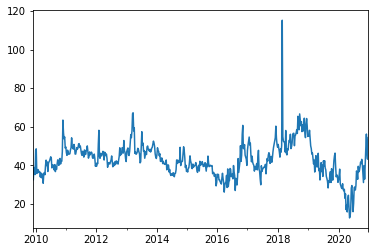

In [47]:
s_wind_capture_prices = weighted_mean_s(s_dam, s_wind)
s_dam_prices = weighted_mean_s(s_dam)

s_wind_capture_prices.plot()

<br>

We'll look at the distribution of the wind capture value ratio

-0.028


<AxesSubplot:ylabel='Count'>

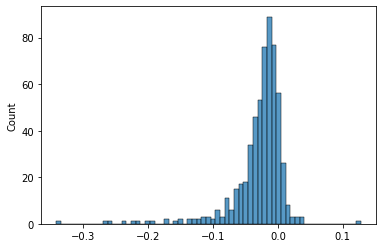

In [48]:
s_wind_capture_value_ratio = (s_wind_capture_prices - s_dam_prices)/s_dam_prices

print(round(s_wind_capture_value_ratio.mean(), 4))
sns.histplot(s_wind_capture_value_ratio)

<br>

We'll look at how this has changed on an annual basis

Text(0, 0.5, 'Wind Capture Price Suppression (%)')

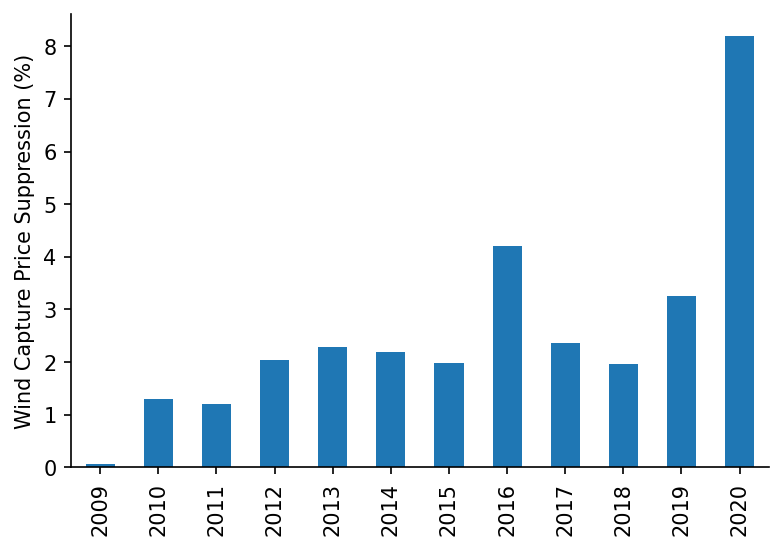

In [50]:
fig, ax = plt.subplots(dpi=150)

(-100*s_wind_capture_value_ratio.groupby(s_wind_capture_value_ratio.index.year).mean()).plot.bar(ax=ax)

eda.hide_spines(ax)
ax.set_ylabel('Wind Capture Price Suppression (%)')

<br>

It could be interesting to look at the effect of price suppression on specific wind farms that have CfDs, and then estimate the increased burden on the tax-payer.

<br>

### German Model

We'll now repeat the price MOE calculations for Germany, starting by loading in the relevant data

In [52]:
%%time

df_DE = eda.load_DE_df('../data/raw/energy_charts.csv', '../data/raw/ENTSOE_DE_price.csv')

df_DE.head()

Wall time: 2.29 s


Biomass  Brown Coal    Gas  Hard Coal  Hydro Power  \
local_datetime                                                                  
2010-01-03 23:00:00+00:00    3.637      16.533  4.726     10.078        2.331   
2010-01-04 00:00:00+00:00    3.637      16.544  4.856      8.816        2.293   
2010-01-04 01:00:00+00:00    3.637      16.368  5.275      7.954        2.299   
2010-01-04 02:00:00+00:00    3.637      15.837  5.354      7.681        2.299   
2010-01-04 03:00:00+00:00    3.637      15.452  5.918      7.498        2.301   

                             Oil  Others  Pumped Storage  Seasonal Storage  \
local_datetime                                                               
2010-01-03 23:00:00+00:00  0.000     0.0           0.052             0.068   
2010-01-04 00:00:00+00:00  0.000     0.0           0.038             0.003   
2010-01-04 01:00:00+00:00  0.000     0.0           0.032             0.000   
2010-01-04 02:00:00+00:00  0.000     0.0           0.027             0.000   
2010-01-04 03:00:00+00:00  0.003     0.0           0.020             0.000   

                           Solar  Uranium   Wind  net_balance  demand  price  
local_datetime                                                                
2010-01-03 23:00:00+00:00    0.0   16.826  0.635       -1.229  53.657    NaN  
2010-01-04 00:00:00+00:00    0.0   16.841  0.528       -1.593  51.963    NaN  
2010-01-04 01:00:00+00:00    0.0   16.846  0.616       -1.378  51.649    NaN  
2010-01-04 02:00:00+00:00    0.0   16.699  0.630       -1.624  50.540    NaN  
2010-01-04 03:00:00+00:00    0.0   16.635  0.713       -0.731  51.446    NaN

<br>

We'll clean up the data and do a quick plot

Text(0, 0.5, 'Price (EUR/MWh)')

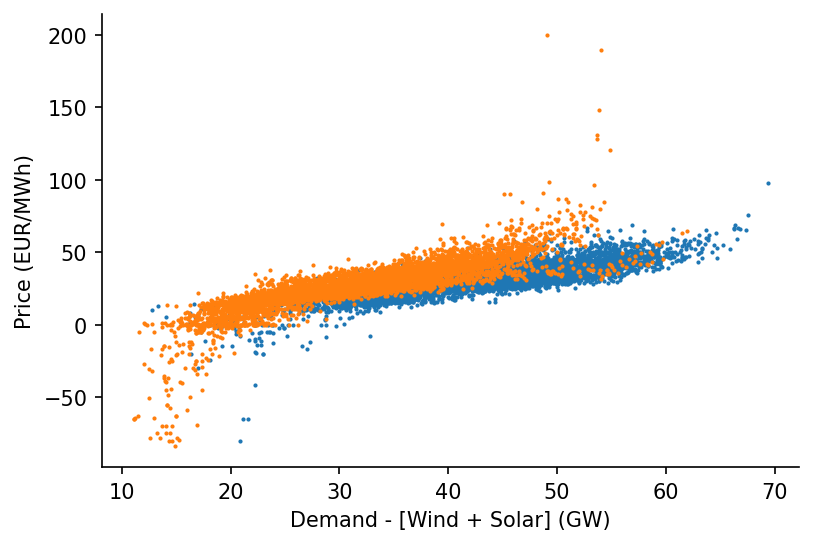

In [53]:
df_DE_model = df_DE[['price', 'demand', 'Solar', 'Wind']].dropna()

s_DE_price = df_DE_model['price']
s_DE_demand = df_DE_model['demand']
s_DE_dispatchable = df_DE_model['demand'] - df_DE_model[['Solar', 'Wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_DE_dispatchable['2015-03':'2015-09'], s_DE_price['2015-03':'2015-09'], s=1)
ax.scatter(s_DE_dispatchable['2020-03':'2020-09'], s_DE_price['2020-03':'2020-09'], s=1)

eda.hide_spines(ax)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('Price (EUR/MWh)')

<br>

Let's create a visualisation that highlights the importance of regressing against dispatchable instead of total load

Wall time: 236 ms


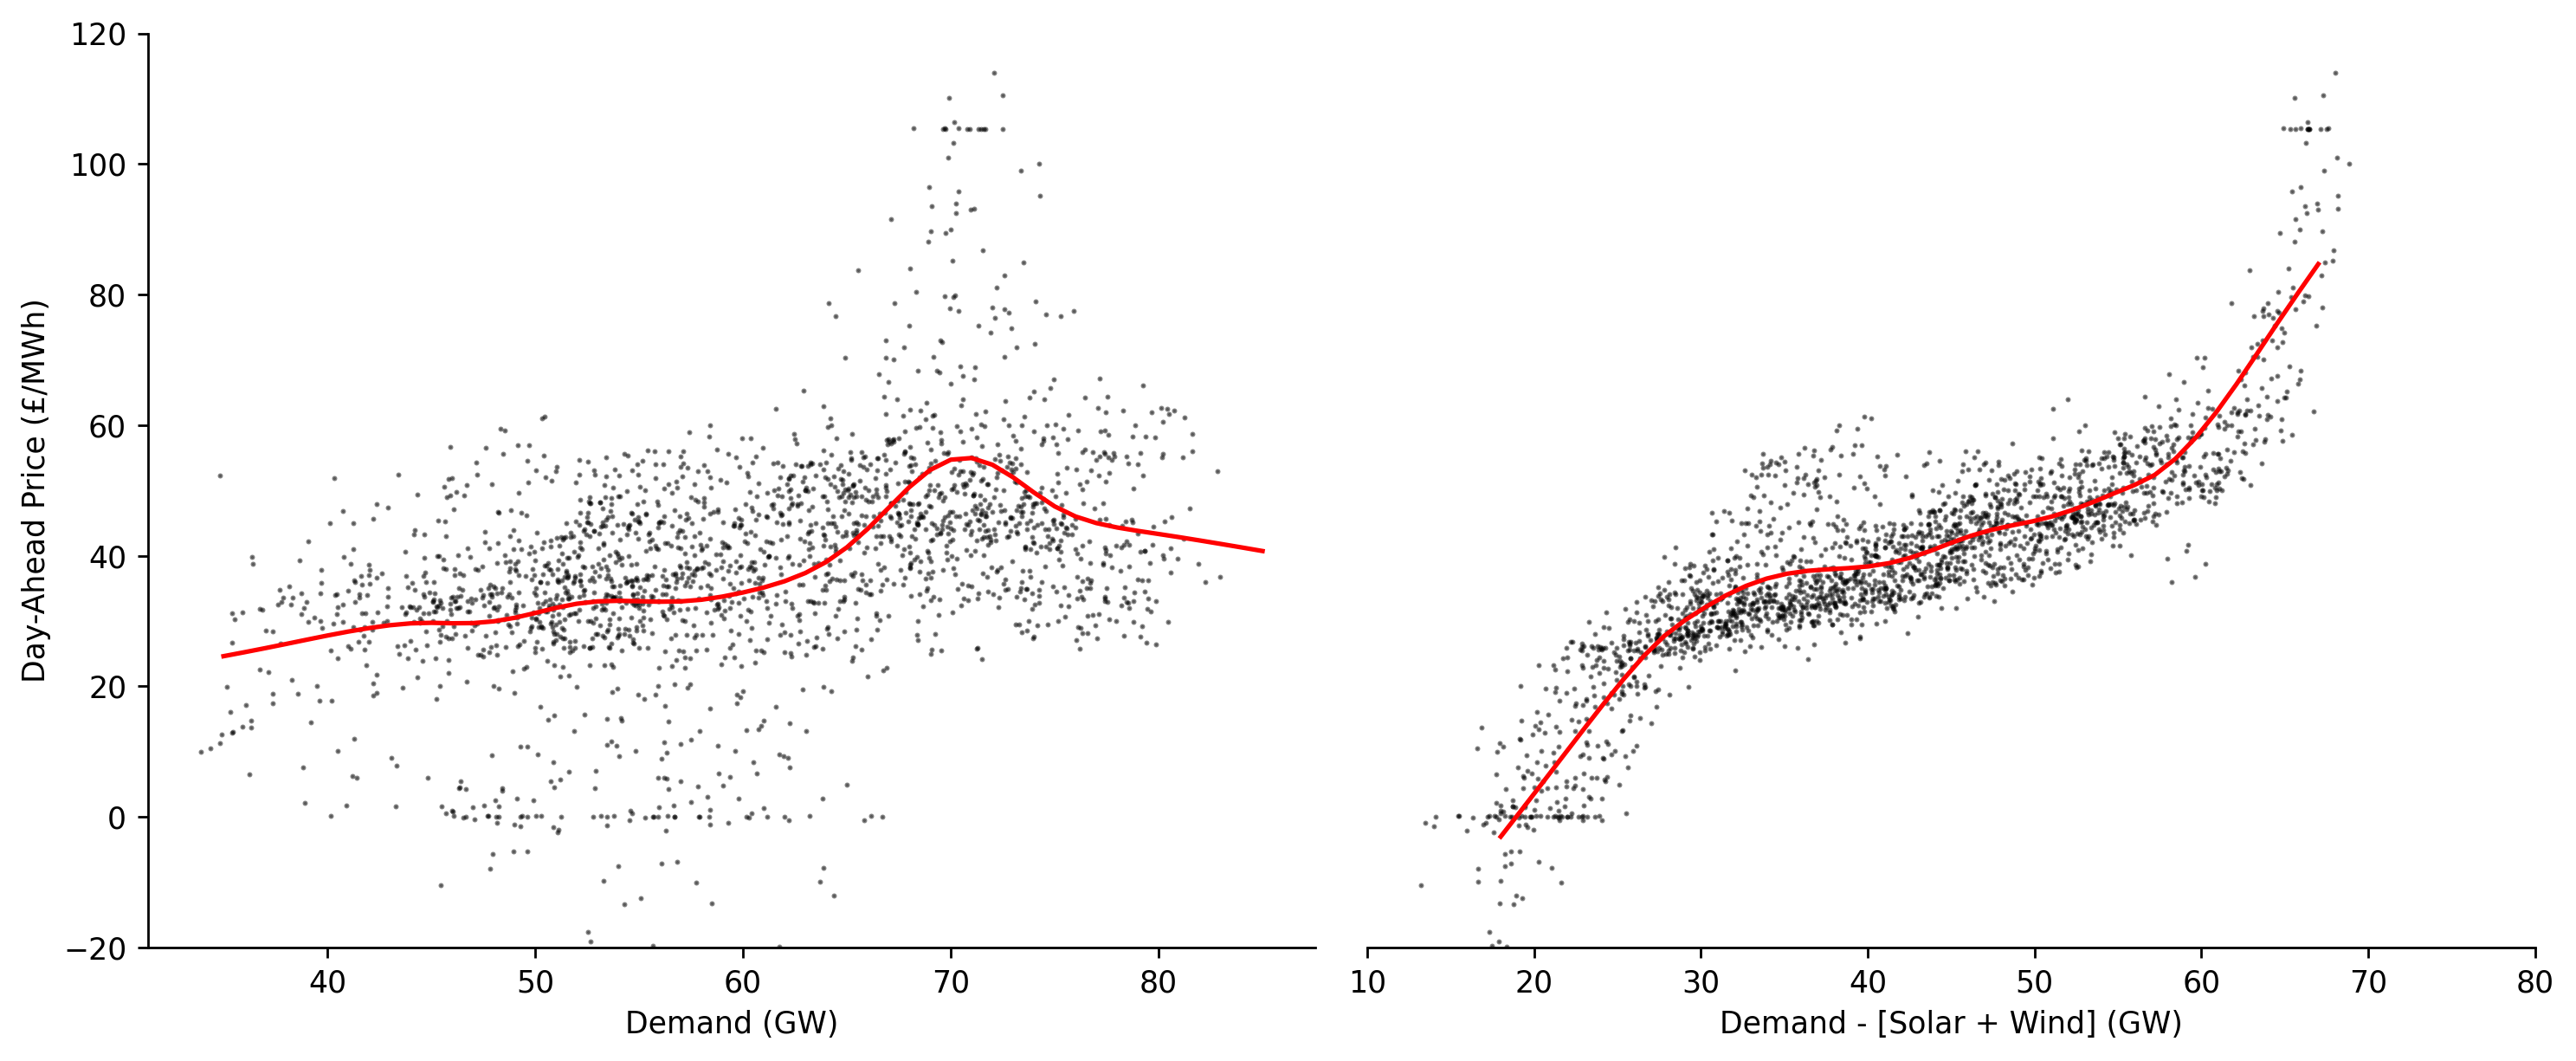

In [54]:
%%time

dt_min = '2020-10'
dt_max = '2020-12'

# Dispatchable
x_dispatch = s_DE_dispatchable[dt_min:dt_max].values
y_dispatch = s_DE_price.loc[s_DE_dispatchable.index][dt_min:dt_max].values

x_pred_dispatch = np.linspace(18, 67, 41)
y_pred_dispatch = lowess.lowess_fit_and_predict(x_dispatch, y_dispatch, frac=0.25, num_fits=50, x_pred=x_pred_dispatch)

# Demand
x_demand = s_DE_demand[dt_min:dt_max].values
y_demand = s_DE_price.loc[s_DE_dispatchable.index][dt_min:dt_max].values

x_pred_demand = np.linspace(35, 85, 51)
y_pred_demand = lowess.lowess_fit_and_predict(x_demand, y_demand, frac=0.25, num_fits=50, x_pred=x_pred_demand)

# Plotting
fig, axs = plt.subplots(dpi=250, ncols=2, figsize=(12, 5))

ax = axs[0]
ax.plot(x_pred_demand, y_pred_demand, linewidth=1.5, color='r')
ax.scatter(x_demand, y_demand, color='k', s=0.5, alpha=0.5)
eda.hide_spines(ax)
ax.set_xlabel('Demand (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

ax = axs[1]
ax.plot(x_pred_dispatch, y_pred_dispatch, linewidth=1.5, color='r')
ax.scatter(x_dispatch, y_dispatch, color='k', s=0.5, alpha=0.5)
ax.set_xlim(10, 80)
eda.hide_spines(ax, positions=['top', 'left', 'right'])
ax.set_yticks([])
ax.set_xlabel('Demand - [Solar + Wind] (GW)')

for ax in axs:
    ax.set_ylim(-20, 120)
    
fig.tight_layout()

<br>

We'll load in our model

In [55]:
%%time

if load_existing_DE_model == True:
    smooth_dates = pickle.load(open(DE_model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2015-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_DE_dispatchable.values, s_DE_price.values, dt_idx=s_DE_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

Wall time: 364 ms


<br>

Generate the regression surface prediction

In [56]:
%%time

x_pred = np.linspace(-5, 90, 951)
dt_pred = pd.date_range('2015-01-01', '2020-12-31', freq='1D')

df_DE_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)
df_DE_pred.index = np.round(df_DE_pred.index, 1)

df_DE_pred.head()

Wall time: 276 ms


2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-05  2015-01-06  \
-5.0  -38.476089  -38.424181  -38.372664  -38.321540  -38.270810  -38.220457   
-4.9  -38.316681  -38.264928  -38.213564  -38.162593  -38.112013  -38.061811   
-4.8  -38.157233  -38.105635  -38.054425  -38.003606  -37.953178  -37.903126   
-4.7  -37.997749  -37.946306  -37.895250  -37.844584  -37.794307  -37.744406   
-4.6  -37.838231  -37.786943  -37.736041  -37.685528  -37.635403  -37.585652   

      2015-01-07  2015-01-08  2015-01-09  2015-01-10  ...  2020-12-22  \
-5.0  -38.170466  -38.120819  -38.071502  -38.022499  ...  -48.264245   
-4.9  -38.011969  -37.962470  -37.913300  -37.864444  ...  -48.028460   
-4.8  -37.853434  -37.804084  -37.755061  -37.706351  ...  -47.792630   
-4.7  -37.694863  -37.645661  -37.596786  -37.548223  ...  -47.556765   
-4.6  -37.536258  -37.487205  -37.438478  -37.390061  ...  -47.320874   

      2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  2020-12-28  \
-5.0  -48.276583  -48.289043  -48.301630  -48.314352  -48.327214  -48.340222   
-4.9  -48.040734  -48.053130  -48.065652  -48.078308  -48.091103  -48.104044   
-4.8  -47.804841  -47.817172  -47.829629  -47.842219  -47.854948  -47.867822   
-4.7  -47.568912  -47.581178  -47.593570  -47.606094  -47.618757  -47.631564   
-4.6  -47.332956  -47.345158  -47.357485  -47.369943  -47.382539  -47.395279   

      2020-12-29  2020-12-30  2020-12-31  
-5.0  -48.353377  -48.366680  -48.380130  
-4.9  -48.117132  -48.130367  -48.143748  
-4.8  -47.880842  -47.894009  -47.907321  
-4.7  -47.644517  -47.657615  -47.670859  
-4.6  -47.408164  -47.421194  -47.434369  

[5 rows x 2192 columns]

<br>

As with the GB market you can see what is likely the effect of higher gas prices in 2018

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Text(69.58333333333334, 0.5, 'Demand - [Solar + Wind] (GW)')

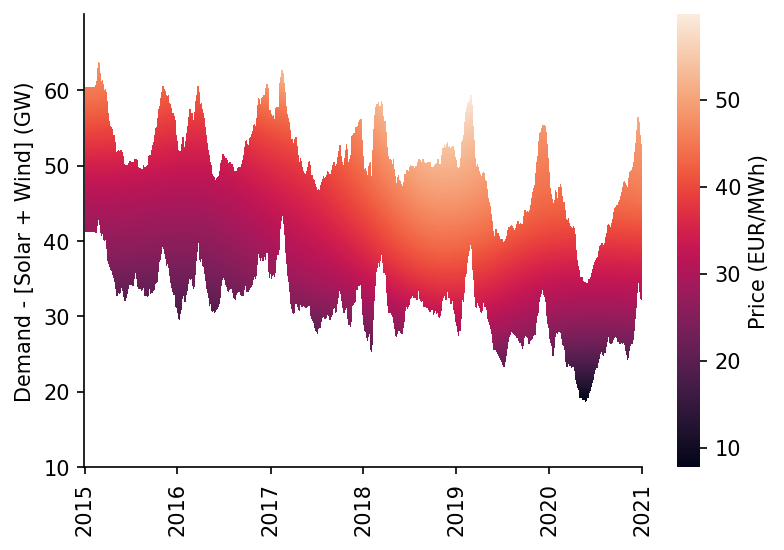

In [57]:
df_DE_dispatchable_lims = construct_dispatchable_lims_df(s_DE_dispatchable, rolling_w=6)
df_DE_pred_mask = construct_pred_mask_df(df_DE_pred, df_DE_dispatchable_lims)

# Plotting
min_y = 10
max_y = 70
fig, ax = plt.subplots(dpi=150)

htmp = sns.heatmap(df_DE_pred[min_y:max_y].where(df_DE_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (EUR/MWh)'})

set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
set_date_ticks(ax, '2015-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
eda.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

<br>

We'll calculate some metrics for our model

In [74]:
s_DE_pred_ts_dispatch, s_DE_pred_ts_demand = get_model_pred_ts(s_DE_dispatchable, DE_model_fp, s_demand=s_DE_demand, x_pred=x_pred, dt_pred=dt_pred)

s_DE_dispatch_err = s_DE_pred_ts_dispatch - s_DE_price.loc[s_DE_pred_ts_dispatch.index]
DE_dispatch_metrics = calc_error_metrics(s_DE_dispatch_err)

s_DE_demand_err = s_DE_pred_ts_demand - s_DE_price.loc[s_DE_pred_ts_demand.index]
DE_demand_metrics = calc_error_metrics(s_DE_demand_err)

DE_dispatch_metrics

{'median_abs_err': 4.257075090332123,
 'mean_abs_err': 5.852023979176648,
 'root_mean_square_error': 8.705711313706535}

<br>

As well as the $r^{2}$ score

In [59]:
# 0.733 for Halttunen2021
r2_score(s_DE_price.loc[s_DE_pred_ts_dispatch.index], s_DE_pred_ts_dispatch)

0.7244797152665161

<br>

We'll now calculate the total savings

In [60]:
start_date = '2015'
end_date = '2020'

s_DE_MOE = s_DE_pred_ts_demand - s_DE_pred_ts_dispatch
s_DE_MOE = s_DE_MOE.dropna()

s_DE_saving = s_DE_MOE * df_DE['demand'].loc[s_DE_MOE.index]*1000
total_saving = s_DE_saving[start_date:end_date].sum()

print(f"The total saving between {start_date} and {end_date} was £{total_saving:,.0f}")

The total saving between 2015 and 2020 was £55,856,316,374


<br>

And get some context for the market average and total volumes over the same period

In [61]:
s_DE_mkt_cost = df_DE['price']*df_DE['demand']*1000

avg_DE_HH_mkt_cost = s_DE_mkt_cost.mean()
total_DE_mkt_cost = s_DE_mkt_cost[start_date:end_date].sum()

avg_DE_HH_mkt_cost, total_DE_mkt_cost

(2076614.8441243432, 109047198694.6575)

<br>

When we plot the percentage MOE over time we can see the large influence of lowered demand in 2020

<AxesSubplot:xlabel='local_datetime'>

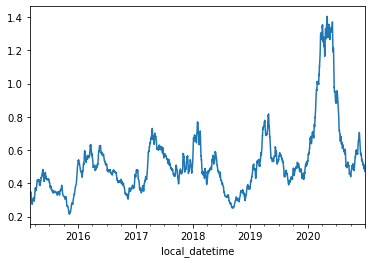

In [62]:
s_DE_MOE_rolling = s_DE_MOE.rolling(48*28).mean().dropna()
s_DE_DAM_rolling = df_DE.loc[s_DE_MOE.index]['price'].rolling(48*28).mean().dropna()

s_DE_MOE_pct_reduction = s_DE_MOE_rolling/s_DE_DAM_rolling

s_DE_MOE_pct_reduction.plot()

<br>

We'll quickly calculate the average percentage price suppresion

In [97]:
s_DE_MOE[start_date:end_date].mean()/(df_DE['price']+s_DE_MOE)[start_date:end_date].mean()

0.3316044469891089

<br>

Of note there appeared to be relatively little impact on the MOE from the effects of the covid-19 response

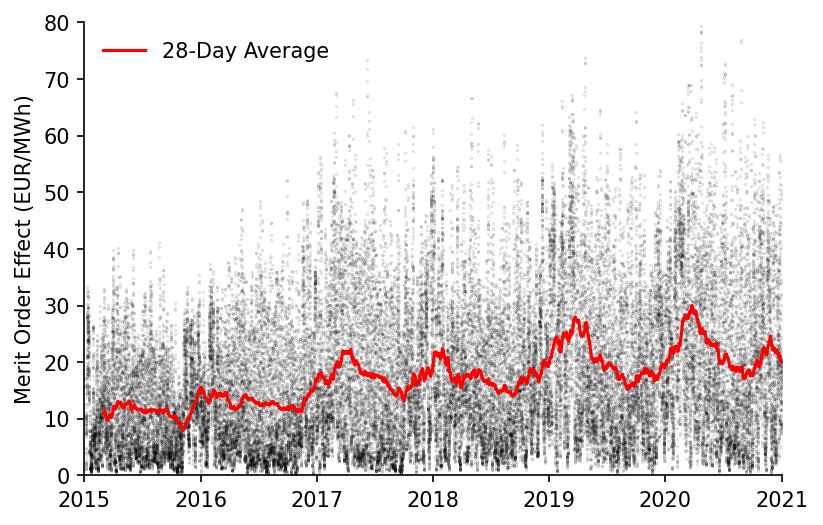

In [64]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_DE_MOE.index, s_DE_MOE, s=0.05, alpha=0.3, color='k', label=None)
ax.plot(s_DE_MOE_rolling.index, s_DE_MOE_rolling, color='r', linewidth=1.5, label='28-Day Average')

eda.hide_spines(ax)
ax.set_ylim(0, 80)
ax.set_xlim(pd.to_datetime('2015'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (EUR/MWh)')
ax.legend(frameon=False)

<br>

Interestingly, the forecast made in 2011 by Traber et al as to the German MOE in 2020 was quite close.

> "In the absence of expanded deployment of renewable energy, a higher price increase of 20% can be expected" in 2020 - [source](https://www.econstor.eu/handle/10419/57678)

In [65]:
s_DE_MOE['2015'].mean(), s_DE_MOE['2020'].mean()

(11.657604746082448, 22.174503965250132)

<br>

We'll now disaggregate the MOE based on the wind and solar drivers

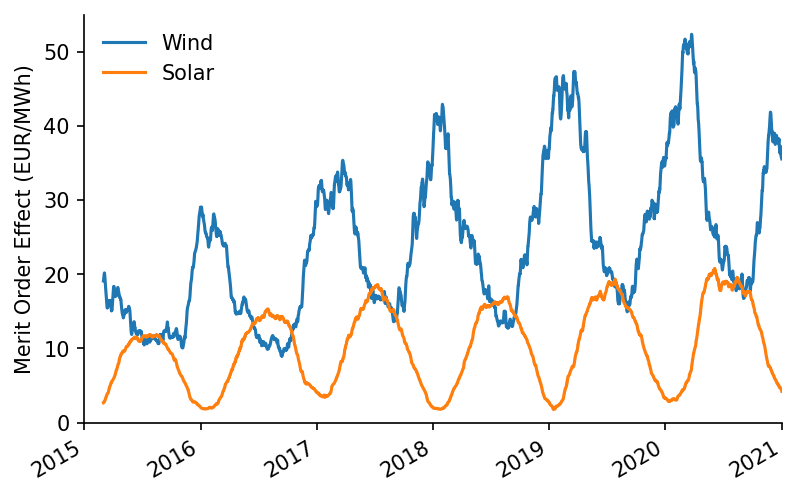

In [66]:
wind_weight = df_DE.loc[s_DE_MOE.index, 'Wind']/df_DE.loc[s_DE_MOE.index][['Wind', 'Solar']].mean(axis=1)
solar_weight = df_DE.loc[s_DE_MOE.index, 'Solar']/df_DE.loc[s_DE_MOE.index][['Wind', 'Solar']].mean(axis=1)

s_wind_MOE = (s_DE_MOE*wind_weight).dropna()
s_solar_MOE = (s_DE_MOE*solar_weight).dropna()

# Plotting
fig, ax = plt.subplots(dpi=150)

s_wind_MOE.rolling(48*28).mean().plot(ax=ax, label='Wind')
s_solar_MOE.rolling(48*28).mean().plot(ax=ax, label='Solar')

ax.set_ylim(0, 55)
ax.set_xlim(pd.to_datetime('2015'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (EUR/MWh)')
ax.legend(frameon=False)
eda.hide_spines(ax)

<br>

We'll look at how the MOE has changed over time in terms of the seasonal effect

Text(0, 0.5, 'Price (EUR/MWh)')

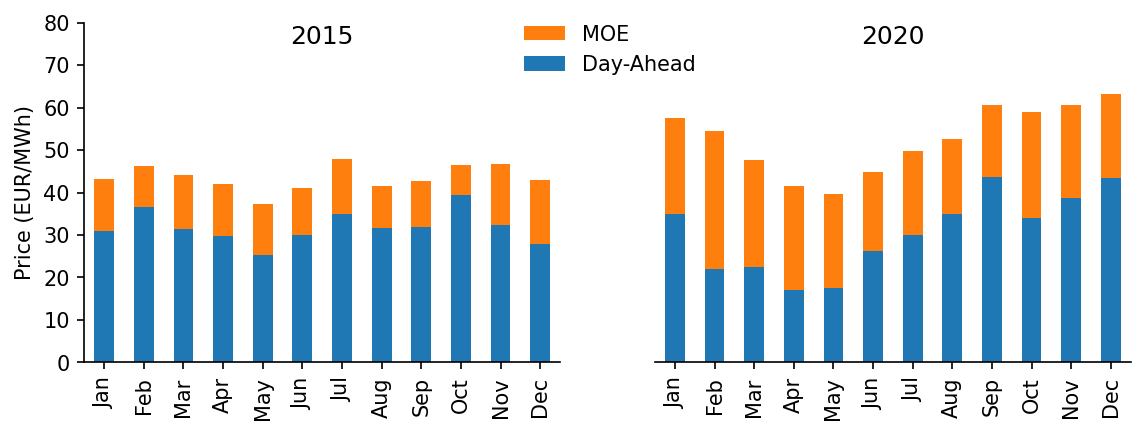

In [67]:
year_1 = '2015'
year_2 = '2020'

s_DE_DAM = df_DE.loc[s_DE_MOE.index, 'price']

month_num_to_name = dict(zip(np.arange(1, 13), pd.date_range('2010-01-01', '2010-12-31', freq='M').strftime('%b')))

s_DE_hourly_dam_10 = s_DE_DAM[year_1].groupby(s_DE_DAM[year_1].index.month).mean()
s_DE_hourly_MOE_10 = s_DE_MOE[year_1].groupby(s_DE_MOE[year_1].index.month).mean()

s_DE_hourly_dam_20 = s_DE_DAM[year_2].groupby(s_DE_DAM[year_2].index.month).mean()
s_DE_hourly_MOE_20 = s_DE_MOE[year_2].groupby(s_DE_MOE[year_2].index.month).mean()

for s in [s_DE_hourly_dam_10, s_DE_hourly_MOE_10, s_DE_hourly_dam_20, s_DE_hourly_MOE_20]:
    s.index = s.index.map(month_num_to_name)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(9, 3))

(s_DE_hourly_dam_10+s_DE_hourly_MOE_10).plot.bar(color='C1', label='MOE', ax=axs[0])
s_DE_hourly_dam_10.plot.bar(label='Price', ax=axs[0])

(s_DE_hourly_dam_20+s_DE_hourly_MOE_20).plot.bar(color='C1', label='MOE', ax=axs[1])
s_DE_hourly_dam_20.plot.bar(label='Day-Ahead', ax=axs[1])

axs[0].set_title(year_1, y=0.9)
axs[1].set_title(year_2, y=0.9)

for ax in axs:
    eda.hide_spines(ax)
    ax.set_ylim(0, 80)
    ax.set_xlabel('')
    
axs[1].legend(frameon=False, bbox_to_anchor=(0.125, 1.05))
axs[1].set_yticks([])
eda.hide_spines(axs[1], positions=['left'])

axs[0].set_ylabel('Price (EUR/MWh)')

<br>

We'll also inspect the predictions on a sample day

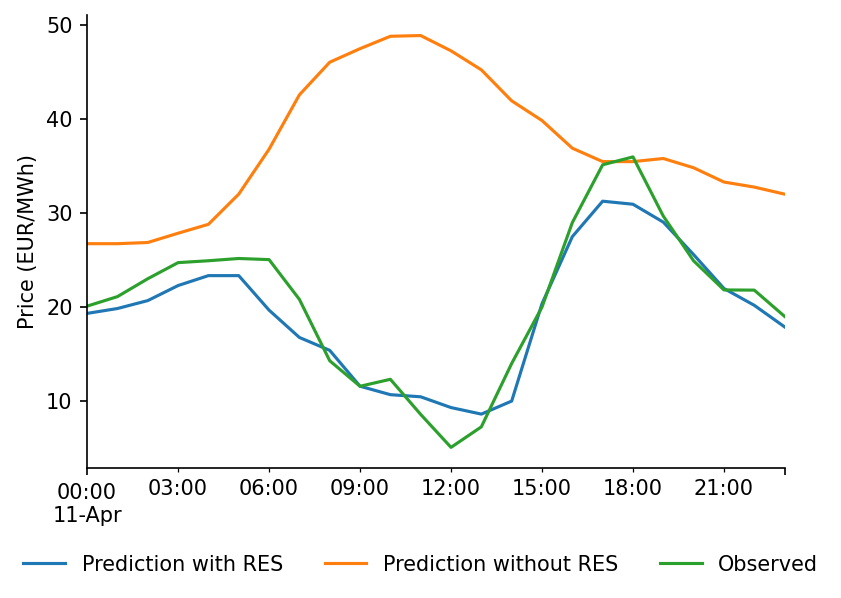

In [68]:
date = '2020-04-11'

# Plotting
fig, ax = plt.subplots(dpi=150)

s_DE_pred_ts_dispatch[date].plot(label='Prediction with RES', ax=ax)
s_DE_pred_ts_demand[date].plot(label='Prediction without RES', ax=ax)
s_DE_price[date].plot(label='Observed', ax=ax)

ax.legend(frameon=False, ncol=3, bbox_to_anchor=(1.075, -0.15))
ax.set_xlabel('')
ax.set_ylabel('Price (EUR/MWh)')
eda.hide_spines(ax)

<br>

There's clearly a correlation between the annual MOE average and the RES percentage penetration

Wall time: 51 ms


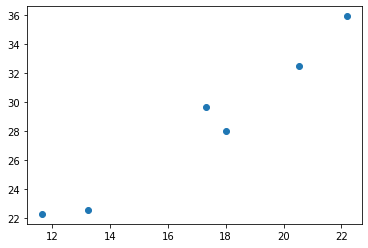

In [151]:
%%time

s_DE_MOE_annual_avg = s_DE_MOE.replace(np.inf, np.nan).dropna().pipe(lambda s: s.groupby(s.index.year).mean())
s_DE_RES_pct_annual_avg = 100*(df_DE[['Wind', 'Solar']].sum(axis=1)/df_DE['demand']).pipe(lambda s: s.groupby(s.index.year).mean()).loc[2015:].dropna()

plt.scatter(s_DE_MOE_annual_avg, s_DE_RES_pct_annual_avg)

<br>

We'll quickly calculate the gradient

In [152]:
linreg_results = scipy.stats.linregress(x=s_DE_RES_pct_annual_avg, y=s_DE_MOE_annual_avg)

linreg_results

LinregressResult(slope=0.7365449501368756, intercept=-3.832555184231513, rvalue=0.9793888213890273, pvalue=0.0006328529981050964, stderr=0.07595057880689415, intercept_stderr=2.196641338586976)

<br>

We'll get some context from the literature

In [159]:
imperial_paper_slope = 0.63

pct_diff = round(100*(linreg_results.slope-imperial_paper_slope)/imperial_paper_slope)

print(f'In this work the MOE increase per percentage penetration of RES was {pct_diff}% higher (for Germany) than the Imperial study')

In this work the MOE increase per percentage penetration of RES was 17% higher (for Germany) than the Imperial study


<br>

### Plots

In this section we'll generate some of the plots needed for the paper, starting with the heatmap of the price surfaces

C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Ayrto\anaconda3\envs\MOE\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


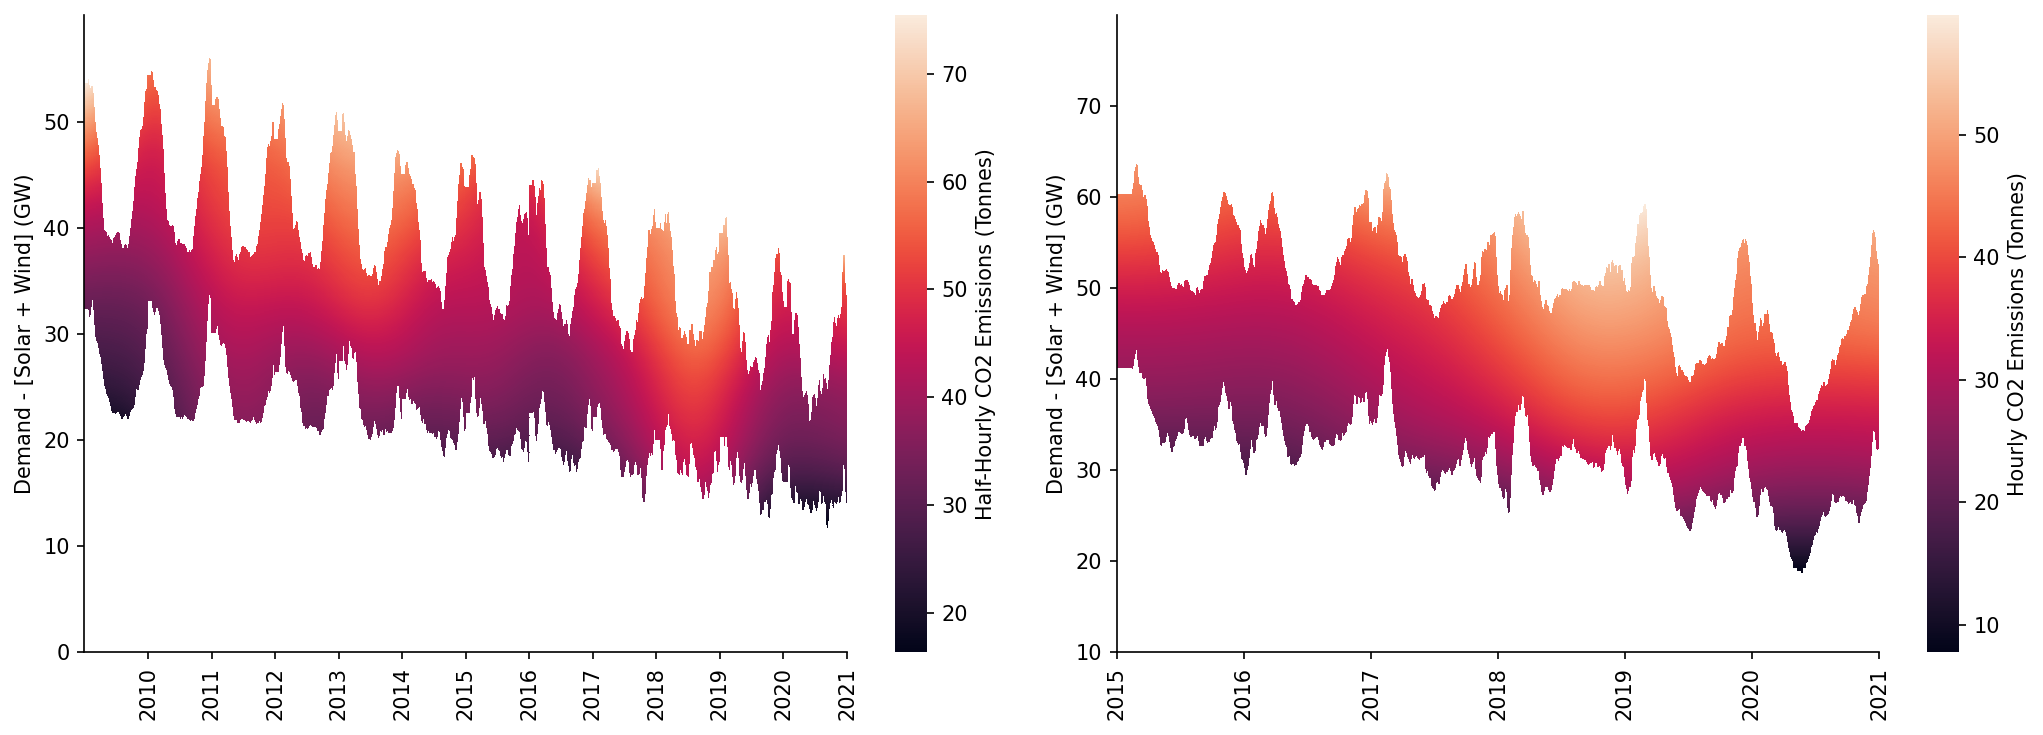

In [69]:
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(14, 5))

# GB
ax = axs[0]
min_y = 0
max_y = 60

htmp = sns.heatmap(df_pred[min_y:max_y].where(df_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Half-Hourly CO2 Emissions (Tonnes)'})

set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
set_date_ticks(ax, '2010-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
eda.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

# DE
ax = axs[1]
min_y = 10
max_y = 80

htmp = sns.heatmap(df_DE_pred[min_y:max_y].where(df_DE_pred_mask[min_y:max_y], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Hourly CO2 Emissions (Tonnes)'})

set_ticks(ax, np.arange(min_y, max_y, 10), axis='y')
set_date_ticks(ax, '2015-01-01', '2021-01-01', freq='1YS', date_format='%Y', axis='x')

for _, spine in htmp.spines.items():
    spine.set_visible(True)
eda.hide_spines(ax)

ax.set_ylabel('Demand - [Solar + Wind] (GW)')

fig.tight_layout()

<br>

We'll also plot the MOE time-series

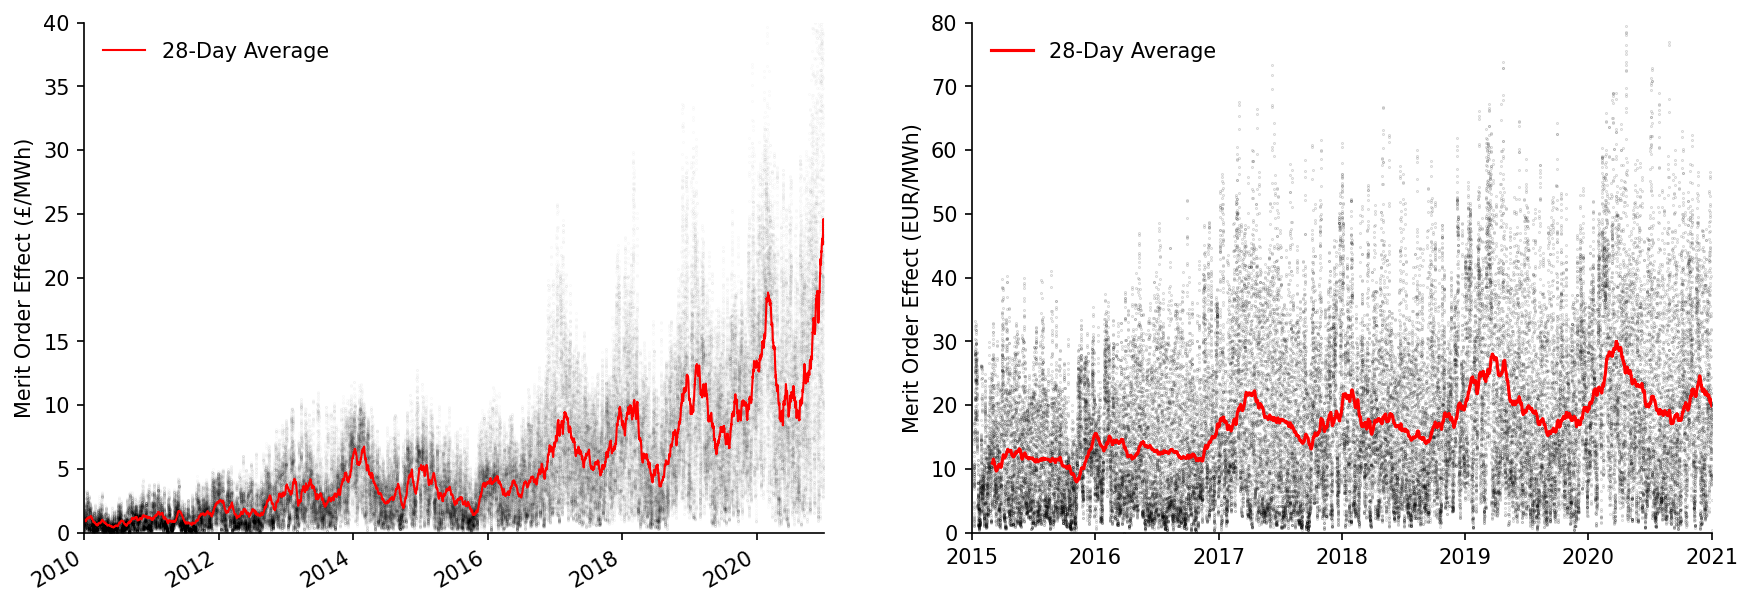

In [70]:
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(14, 5))

# GB
ax = axs[0]

ax.scatter(s_GB_MOE.index, s_GB_MOE, s=0.01, alpha=0.1, color='k', label=None)
s_GB_MOE_rolling.plot(color='r', linewidth=1, ax=ax, label='28-Day Average')

eda.hide_spines(ax)
ax.set_ylim(0, 40)
ax.set_xlim(pd.to_datetime('2010'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (£/MWh)')
ax.legend(frameon=False)

# DE
ax = axs[1]

ax.scatter(s_DE_MOE.index, s_DE_MOE, s=0.05, alpha=0.3, color='k', label=None)
ax.plot(s_DE_MOE_rolling.index, s_DE_MOE_rolling, color='r', linewidth=1.5, label='28-Day Average')

eda.hide_spines(ax)
ax.set_ylim(0, 80)
ax.set_xlim(pd.to_datetime('2015'), pd.to_datetime('2021'))
ax.set_xlabel('')
ax.set_ylabel('Merit Order Effect (EUR/MWh)')
ax.legend(frameon=False)

<br>

### Saving Results

Additionaly we'll save the time-series predictions and model metrics, starting with the GB time-series

In [87]:
df_GB_results_ts = pd.DataFrame({
    'prediction': s_GB_pred_ts_dispatch,
    'counterfactual': s_GB_pred_ts_demand,
    'observed': s_GB_price,
    'moe': s_GB_MOE
})

df_GB_results_ts.head()

prediction  counterfactual  observed       moe
local_datetime                                                           
2009-01-01 00:00:00+00:00   37.203441       37.313379     58.05  0.109938
2009-01-01 00:30:00+00:00   37.313379       37.535135     56.33  0.221756
2009-01-01 01:00:00+00:00   36.768513       36.985087     52.98  0.216574
2009-01-01 01:30:00+00:00   35.595162       35.807631     50.39  0.212469
2009-01-01 02:00:00+00:00   34.849422       35.063119     48.70  0.213697

<br>

Which we'll save to csv

In [ ]:
df_GB_results_ts.to_csv('../data/results/GB_price.csv')

<br>

Then the DE time-series

In [89]:
df_DE_results_ts = pd.DataFrame({
    'prediction': s_DE_pred_ts_dispatch,
    'counterfactual': s_DE_pred_ts_demand,
    'observed': s_DE_price,
    'moe': s_DE_MOE
})

df_DE_results_ts.to_csv('../data/results/DE_price.csv')

df_DE_results_ts.head()

prediction  counterfactual  observed        moe
local_datetime                                                            
2015-01-04 23:00:00+00:00   24.496292       34.530421     22.34  10.034130
2015-01-05 00:00:00+00:00   23.758428       33.626015     17.93   9.867587
2015-01-05 01:00:00+00:00   23.662602       33.924488     15.17  10.261886
2015-01-05 02:00:00+00:00   24.134178       34.531475     16.38  10.397297
2015-01-05 03:00:00+00:00   24.934345       36.210384     17.38  11.276039

<br>

And finally the model metrics for both

In [83]:
model_accuracy_metrics = {
    'DE_dispatch': DE_dispatch_metrics,
    'DE_demand': DE_demand_metrics,
    'GB_dispatch': GB_dispatch_metrics,
    'GB_demand': GB_demand_metrics
}

with open('../data/results/price_model_accuracy_metrics.json', 'w') as fp:
    json.dump(model_accuracy_metrics, fp)

JSON(model_accuracy_metrics)

<IPython.core.display.JSON object>

In [1]:
#hide
from nbdev.export import *
notebook2script()

Converted dev-01-retrieval.ipynb.
Converted dev-02-eda.ipynb.
Converted dev-03-lowess.ipynb.
Converted dev-04-price-surface-estimation.ipynb.
Converted dev-05-price-moe.ipynb.
Converted dev-06-carbon-surface-estimation-and-moe.ipynb.
Converted dev-07-prediction-confidence-and-intervals.ipynb.
Converted dev-08-hyper-parameter-tuning.ipynb.
Converted dev-09-tables-and-figures.ipynb.
Converted dev-10-ci-cd.ipynb.
Converted ug-01-hydro-seasonality.ipynb.
Converted ug-02-ligo.ipynb.
Converted ug-03-power-curve.ipynb.
Converted ug-04-electricity-prices.ipynb.
Converted ug-05-data-retrieval.ipynb.
Converted ug-06-surface-estimation.ipynb.
Converted ug-07-moe-quantification.ipynb.
Converted ug-08-lowess-quick-start.ipynb.
